**1. Life Cycle Model - Stochastic**

In [3]:
"""

model.py
--------
This code sets up the model.

"""

#%% Imports from Python
from numpy import count_nonzero,exp,expand_dims,linspace,log,tile
from scipy import stats
from types import SimpleNamespace

#%% Deterministic Life Cycle Model.
class household():
    '''

    Methods:
        __init__(self,**kwargs) -> Set the household's attributes.
        setup(self,**kwargs) -> Sets parameters.

    '''

    #%% Constructor.
    def __init__(self,**kwargs):
        '''

        This initializes the model.

        Optional kwargs:
            All parameters changed by setting kwarg.

        '''

        print('--------------------------------------------------------------------------------------------------')
        print('Model')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The model is the stochastic life cycle model and is solved via Backward Induction.')

        print('\n--------------------------------------------------------------------------------------------------')
        print('Household')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The household is fintely-lived and dies after T periods.')
        print('   It derives utility from consumption.')
        print('    -> He/she retires after tr periods.')

    #%% Set up model.
    def setup(self,**kwargs):
        '''

        This sets the parameters and creates the grids for the model.

            Input:
                self : Model class.
                kwargs : Values for parameters if not using the default.

        '''

        # Namespace for parameters, grids, and utility function.
        setattr(self,'par',SimpleNamespace())
        par = self.par

        print('\n--------------------------------------------------------------------------------')
        print('Parameters:')
        print('--------------------------------------------------------------------------------\n')

        # Preferences.
        par.beta = 0.94 # Discount factor.
        par.gamma = 2.0 # CRRA.

        # Demographics.
        par.T = 61 # Last period of life.
        par.tr = 41 # First period of retirement.

        # Prices and Income.
        par.r = 0.03 # Interest rate.
        par.kappa = 0.6 # Share of income as pension.

        par.sigma_eps = 0.07 # Std. dev of productivity shocks.
        par.rho = 0.85 # Persistence of AR(1) process.
        par.mu = 0.0 # Intercept of AR(1) process.

        par.ylen = 7 # Grid size for y.
        par.m = 3 # Scaling parameter for Tauchen.

        # Simulation parameters.
        par.seed_sim = 3000 # Seed for simulation.
        par.TT = 61 # Number of time periods.
        par.NN = 10000 # Number of time periods.

        # Set up asset grid.
        par.alen = 300 # Grid size for a.
        par.amax = 30.0 # Upper bound for a.
        par.amin = 0.0 # Minimum a.

        # Update parameter values to kwarg values if you don't want the default values.
        for key,val in kwargs.items():
            setattr(par,key,val)

        assert par.beta > 0.0 and par.beta < 1.0
        assert par.gamma >= 1.00
        assert par.sigma_eps > 0.00
        assert abs(par.sigma_eps) < 1.00
        assert par.kappa >= 0.0 and par.kappa <= 1.0
        assert par.alen > 5
        assert par.amax > par.amin

        # Set up asset grid.
        par.agrid = linspace(par.amin,par.amax,par.alen) # Equally spaced, linear grid for a (and a').

        # Discretize productivity.
        ygrid,pmat = tauchen(par.mu,par.rho,par.sigma_eps,par.ylen,par.m) # Tauchen's Method to discretize the AR(1) process for log productivity.
        par.ygrid = exp(ygrid) # The AR(1) is in logs so exponentiate it to get A.
        par.pmat = pmat # Transition matrix.

        # Utility function.
        par.util = util

        print('beta: ',par.beta)
        print('gamma: ',par.gamma)
        print('amin: ',par.amin)
        print('amax: ',par.amax)
        print('kappa: ',par.kappa)

#%% CRRA Utility Function.
def util(c,gamma):

    # CRRA utility
    if gamma == 1.0:
        u = log(c) # Log utility.
    else:
        u = (c**(1.0-gamma))/(1.0-gamma) # CRRA utility.

    return u

#%% Tauchen's Method.
def tauchen(mu,rho,sigma,N,m):

    #%% Construct equally spaced grid.

    ar_mean = mu/(1.0-rho) # The mean of a stationary AR(1) process is mu/(1-rho).
    ar_sd = sigma/((1.0-rho**2.0)**(1/2)) # The std. dev of a stationary AR(1) process is sigma/sqrt(1-rho^2)

    y1 = ar_mean-(m*ar_sd) # Smallest grid point is the mean of the AR(1) process minus m*std.dev of AR(1) process.
    yn = ar_mean+(m*ar_sd) # Largest grid point is the mean of the AR(1) process plus m*std.dev of AR(1) process.

    y,d = linspace(y1,yn,N,endpoint=True,retstep=True) # Equally spaced grid. Include endpoint (endpoint=True) and record stepsize, d (retstep=True).

    #%% Compute transition probability matrix from state j (row) to k (column).

    ymatk = tile(expand_dims(y,axis=0),(N,1)) # Container for state next period.
    ymatj = mu+rho*ymatk.T # States this period.

    # In the following, loc and scale are the mean and std used to standardize the variable. # For example, norm.cdf(x,loc=y,scale=s) is the standard normal CDF evaluated at (x-y)/s.
    pmat = stats.norm.cdf(ymatk,loc=ymatj-(d/2.0),scale=sigma)-stats.norm.cdf(ymatk,loc=ymatj+(d/2.0),scale=sigma) # Transition probabilities to state 2, ..., N-1.
    pmat[:,0] = stats.norm.cdf(y[0],loc=mu+rho*y-(d/2.0),scale=sigma) # Transition probabilities to state 1.
    pmat[:,N-1] = 1.0-stats.norm.cdf(y[N-1],loc=mu+rho*y+(d/2.0),scale=sigma) # Transition probabilities to state N.

    #%% Output.

    y = expand_dims(y,axis=0) # Convert 0-dimensional array to a row vector.

    if count_nonzero(pmat.sum(axis=1)<0.999999) > 0:
        raise Exception("Some columns of transition matrix don't sum to 1.")

    return y,pmat

In [4]:
"""

solve.py
--------
This code solves the model.

"""

#%% Imports from Python
from numpy import argmax,expand_dims,inf,squeeze,tile,zeros,seterr
from types import SimpleNamespace
import time
seterr(divide='ignore')
seterr(invalid='ignore')

#%% Solve the model using Backward Induction.
def experience_life(myClass):
    '''

    This function solves the stochastic life cycle model.

    Input:
        myClass : Model class with parameters, grids, and utility function.

    '''

    print('\n--------------------------------------------------------------------------------------------------')
    print('Solving the Model by Backward Induction')
    print('--------------------------------------------------------------------------------------------------\n')

    # Namespace for optimal policy funtions.
    setattr(myClass,'sol',SimpleNamespace())
    sol = myClass.sol

    # Model parameters, grids and functions.

    par = myClass.par # Parameters.

    T = par.T # Last period of life.
    tr = par.tr # First year of retirement.

    beta = par.beta # Discount factor.
    gamma = par.gamma # CRRA.

    alen = par.alen # Grid size for a.
    agrid = par.agrid # Grid for a (state and choice).

    ylen = par.ylen # Grid size for y.
    ygrid = par.ygrid # Grid for y.
    pmat = par.pmat # Transition matrix for y.

    r = par.r # Real interest rate.
    kappa = par.kappa # Share of income as pension.

    util = par.util # Utility function.

    amat = tile(expand_dims(agrid,axis=1),(1,ylen)) # k for each value of A.
    ymat = tile(expand_dims(ygrid,axis=0),(alen,1)) # A for each value of k.

    # Containers.
    v1 = zeros((alen,T,ylen)) # Container for V.
    a1 = zeros((alen,T,ylen)) # Container for a'.
    c1 = zeros((alen,T,ylen)) # Container for c.

    t0 = time.time()

    for age in reversed(range(T)): # Iterate on the Bellman Equation until convergence.

        if age == T-1: # Python index starts at 0 and does not include the upper limit.

            c1[:,age,:] = amat + kappa*ymat
            a1[:,age,:] = 0.0
            v1[:,age,:] = util(c1[:,age,:],gamma)

        else:

            for i in range(ylen): # Loop over the y-states.

                if age >= tr: # Workers get a salary; retiress get a pension.
                    yt = kappa*ygrid[0][i]
                    ev = squeeze(v1[:,age+1,i])
                else:
                    yt = ygrid[0][i]
                    ev = squeeze(squeeze(v1[:,age+1,:])@pmat[i,:].T)

                for p in range(0,alen): # Loop over the a-states.

                    # Consumption.
                    ct = agrid[p]+yt-(agrid/(1.0+r))
                    ct[ct<0.0] = 0.0

                    # Solve the maximization problem.
                    vall = util(ct,gamma) + beta*ev # Compute the value function for each choice of a', given a.
                    vall[ct<=0.0] = -inf # Set the value function to negative infinity number when c <= 0.
                    v1[p,age,i] = max(vall) # Maximize: vmax is the maximized value function; ind is where it is in the grid.
                    a1[p,age,i] = agrid[argmax(vall)] # Optimal a'.
                    c1[p,age,i] = ct[argmax(vall)] # Optimal a'.

        # Print counter.
        if age%5 == 0:
            print('Age: ',age,'.\n')

    t1 = time.time()
    print('Elapsed time is ',t1-t0,' seconds.')

    # Macro variables, value, and policy functions.
    sol.c = c1 # Consumption policy function.
    sol.a = a1 # Saving policy function.
    sol.v = v1 # Value function.

In [5]:
"""

simulate.py
-----------
This code simulates the model.

"""

#%% Imports from Python
from numpy import cumsum,empty,linspace,nan,squeeze,where,zeros
from numpy.random import choice,rand,seed
from numpy.linalg import matrix_power
from types import SimpleNamespace

#%% Simulate the model.
def grow_old_and_die(myClass):
    '''

    This function simulates the deterministic life cycle model.

    Input:
        myClass : Model class with parameters, grids, utility function, and policy functions.

    '''

    print('\n--------------------------------------------------------------------------------------------------')
    print('Simulate the Model')
    print('--------------------------------------------------------------------------------------------------\n')

    # Namespace for simulation.
    setattr(myClass,'sim',SimpleNamespace())
    sim = myClass.sim

    # Model parameters, grids and functions.

    par = myClass.par # Parameters.
    sol = myClass.sol # Policy functions.

    sigma = par.gamma # CRRA.
    util = par.util # Utility function.
    seed_sim = par.seed_sim # Seed for simulation.

    T = par.T # Last period of life.
    tr = par.tr # First year retired.

    kappa = par.kappa # Share of income as pension.
    ygrid = par.ygrid # Exogenous income.
    pmat = par.pmat # Transition matrix.

    alen = par.alen # Asset grid size.
    agrid = par.agrid # Assets today (state).

    apol = sol.a # Policy function for savings.
    cpol = sol.c # Policy function for consumption.

    TT = par.TT # Time periods.
    NN = par.NN # Population size.

    tsim = empty((TT,NN)) * nan # Container for simulated age.
    ysim = empty((TT,NN)) * nan # Container for simulated income.
    csim = empty((TT,NN)) * nan # Container for simulated consumption.
    asim = empty((TT,NN)) * nan # Container for simulated savings.
    usim = empty((TT,NN)) * nan # Container for simulated utility.

    # Begin simulation.

    seed(seed_sim)

    pmat0 = matrix_power(pmat,1000)
    pmat0 = pmat0[0,:] # % Stationary distribution.
    cmat = cumsum(par.pmat,axis=1) # CDF matrix.

    y0_ind = choice(linspace(0,par.ylen,par.ylen,endpoint=False,dtype=int),NN,p=pmat0) # Index for initial income.
    t0_ind = choice(linspace(0,T,T,endpoint=False,dtype=int),NN) # Index for initial wealth.
    a0_ind = choice(linspace(0,alen,alen,endpoint=False,dtype=int),NN) # Index for initial wealth.
    yr = empty((NN,1)) # Retirement income.

    for i in range(0,NN):
        tsim[0,i] = t0_ind[i] # Simulated age.

        if t0_ind[i] < tr: # Simulated income.
            ysim[0,i] = ygrid[0][y0_ind[i]]
        else:
            ysim[0,i] = kappa*ygrid[0][y0_ind[i]]

        csim[0,i] = cpol[a0_ind[i],t0_ind[i],y0_ind[i]] # Consumption in period 1 given a0.
        asim[0,i] = apol[a0_ind[i],t0_ind[i],y0_ind[i]] # Savings given a0.
        usim[0,i] = util(csim[0,i],sigma) # Utility in period 1 given a0 and age.

        if t0_ind[i] == tr-1: # Retired next period.
            yr[i] = ygrid[0][y0_ind[i]] # Store as pension for next period
        elif t0_ind[i] < tr-1:
            y1_ind = where(rand(1)<=squeeze(cmat[y0_ind[i],:])) # Draw income shock for next period.
            y0_ind[i] = y1_ind[0][0]

    # Simulate endogenous variables.

    for j in range(1,TT): # Time loop.
        for i in range(0,NN): # Person loop.

            if tsim[j-1,i]+1 <= T-1: # Check if still alive.
                tsim[j,i] = tsim[j-1,i]+1 # Age in period t.

                if tsim[j,i] < tr: # Income given age.
                    ysim[j,i] = ygrid[0][y0_ind[i]]
                else:
                    ysim[j,i] = kappa*yr[i]

                at_ind = where(asim[j-1,i]==agrid)[0] # Savings choice in the previous period is the state today. Find where the latter is on the grid.

                csim[j,i] = cpol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Consumption in period t.
                asim[j,i] = apol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Savings for period t+1.
                usim[j,i] = util(csim[j,i],sigma) # Utility in period t.

                if tsim[j-1,i]+1 == tr-1: # Retire next period
                    yr[i] = ygrid[0][y0_ind[i]] # Store as pension for next period
                elif tsim[j-1,i]+1 < tr-1:
                    y1_ind = where(rand(1)<=squeeze(cmat[y0_ind[i],:])) # Draw income shock for next period.
                    y0_ind[i] = y1_ind[0][0]

    # Simulated model.
    sim.ysim = ysim # Simulated income.
    sim.tsim = tsim # Simulated age.
    sim.csim = csim # Simulated consumption.
    sim.asim = asim # Simulated savings.
    sim.usim = usim # Simulated utility.

    print('Simulation done.\n')
    print('--------------------------------------------------------------------------------------------------\n')

In [6]:
"""

my_graph.py
-----------
This code plots the value and policy functions.

"""

#%% Imports from Python
from matplotlib.pyplot import figure,plot,xlabel,ylabel,title,show
from numpy import linspace,nanmean,squeeze,zeros

#%% Plot the model functions and simulations.
def track_aging(myClass):
    '''

    This function plots the model functions and simulations.

    Input:
        myClass : Model class with parameters, grids, utility function, policy functions, and simulations.

    '''

    # Model parameters, policy and value functions, and simulations.
    par = myClass.par # Parameters.
    sol = myClass.sol # Policy functions.
    sim = myClass.sim # Simulations.

    age = linspace(0,par.T,par.T,endpoint=False,dtype=int)

    # Plot savings policy function.

    figure(1)
    plot(age,squeeze(sol.a[0,:,:]))
    xlabel('$Age$')
    ylabel('$a_{t+1}$')
    title('Savings Policy Function, Lowest $a_t$')

    figure(2)
    plot(age,squeeze(sol.a[par.alen-1,:,:]))
    xlabel('$Age$')
    ylabel('$a_{t+1}$')
    title('Savings Policy Function, Highest $a_t$')

    # Plot consumption policy function.

    figure(3)
    plot(age,squeeze(sol.c[0,:,:]))
    xlabel('$Age$')
    ylabel('$c_{t}$')
    title('Consumption Policy Function, Lowest $a_t$')

    figure(4)
    plot(age,squeeze(sol.c[par.alen-1,:,:]))
    xlabel('$Age$')
    ylabel('$c_{t}$')
    title('Consumption Policy Function, Highest $a_t$')

    # Plot value function.

    figure(5)
    plot(age,squeeze(sol.v[0,:,:]))
    xlabel('$Age$')
    ylabel('$V_t(k_t)$')
    title('Value Function, Lowest $a_t$')

    figure(6)
    plot(age,squeeze(sol.v[par.alen-1,:,:]))
    xlabel('$Age$')
    ylabel('$V_t(k_t)$')
    title('Value Function, Highest $a_t$')

    # Plot simulated income.

    lcp_c = zeros((par.T,1))
    lcp_a = zeros((par.T,1))
    lcp_u = zeros((par.T,1))

    for i in range(par.T):
        lcp_c[i] = nanmean(sim.csim[sim.tsim==i])
        lcp_a[i] = nanmean(sim.asim[sim.tsim==i])
        lcp_u[i] = nanmean(sim.usim[sim.tsim==i])

    # Plot simulated consumption.

    figure(7)
    plot(age,lcp_c)
    xlabel('Age')
    ylabel('$c^{sim}_{t}$')
    title('Simulated Consumption')

    # Plot simulated savings.

    figure(8)
    plot(age,lcp_a)
    xlabel('Age')
    ylabel('$a^{sim}_{t+1}$')
    title('Simulated Savings')

    # Plot simulated utility.

    figure(9)
    plot(age,lcp_u)
    xlabel('Age')
    ylabel('$u^{sim}_t$')
    title('Simulated Utility')

    #show()


--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the stochastic life cycle model and is solved via Backward Induction.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is fintely-lived and dies after T periods.
   It derives utility from consumption.
    -> He/she retires after tr periods.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
gamma:  2.0
amin:  0.0
amax:  30.0
kappa:  0.6

--------------------------------------------------------------------------------------------------
Solving the Model by Bac

<ipython-input-5-6d21752bfe8c>:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  csim[j,i] = cpol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Consumption in period t.
<ipython-input-5-6d21752bfe8c>:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asim[j,i] = apol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Savings for period t+1.
<ipython-input-5-6d21752bfe8c>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ysim[j,i] = kappa*yr[i]


Simulation done.

--------------------------------------------------------------------------------------------------



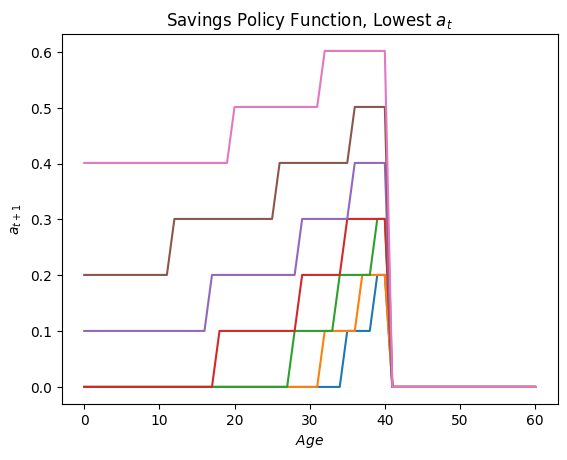

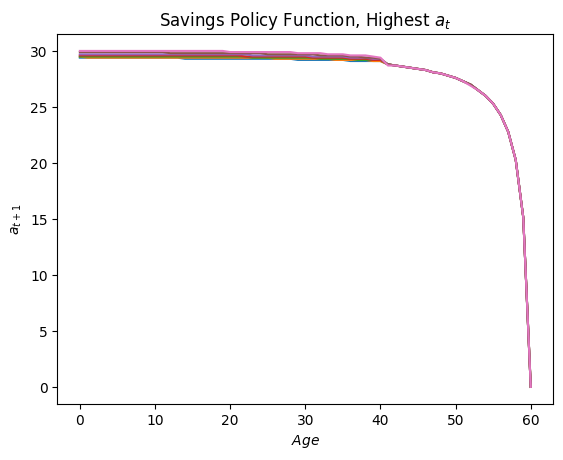

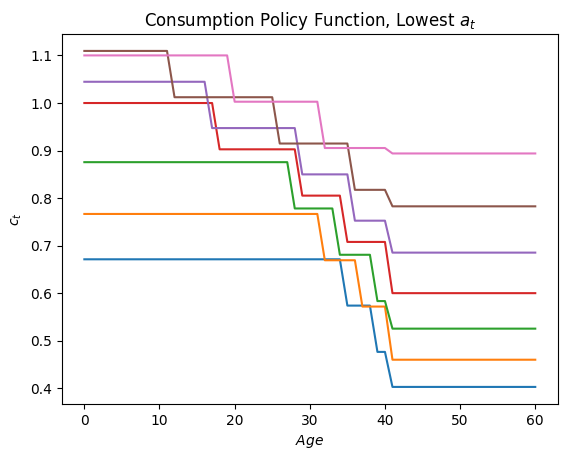

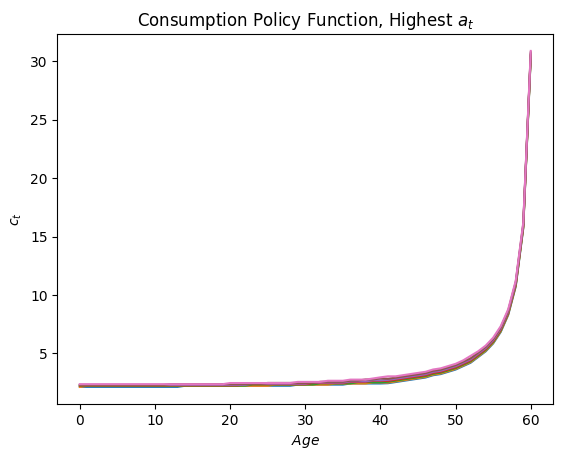

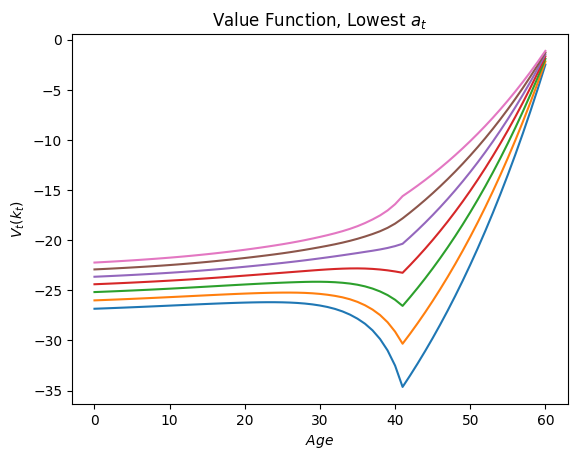

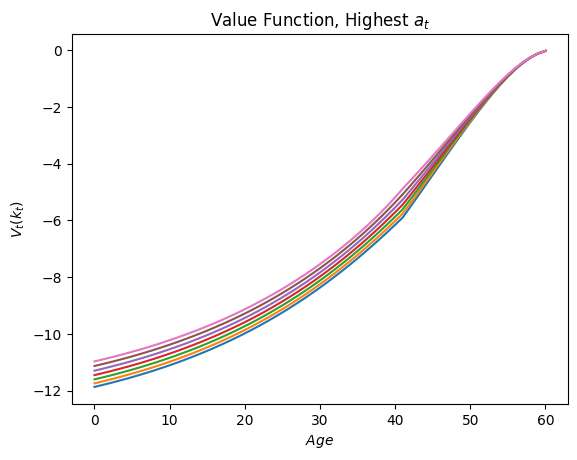

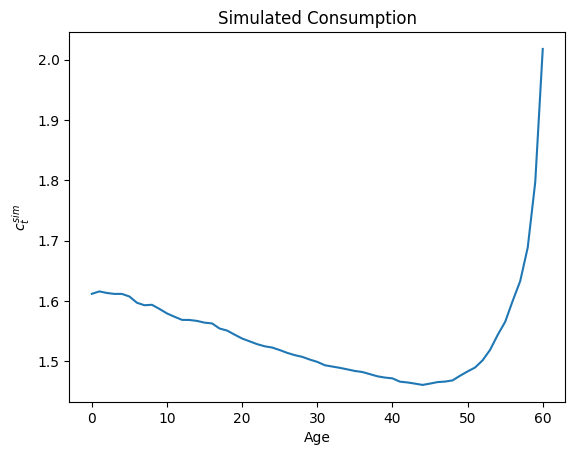

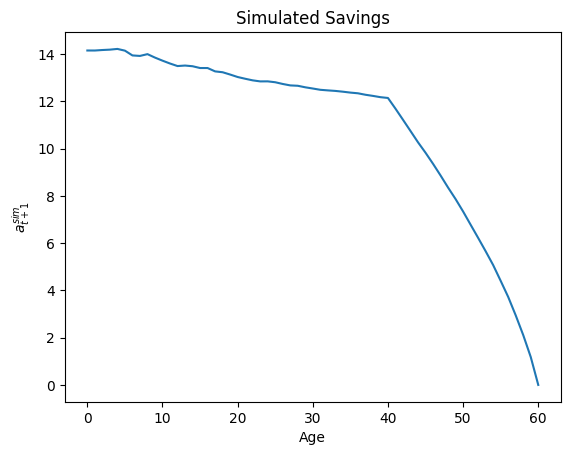

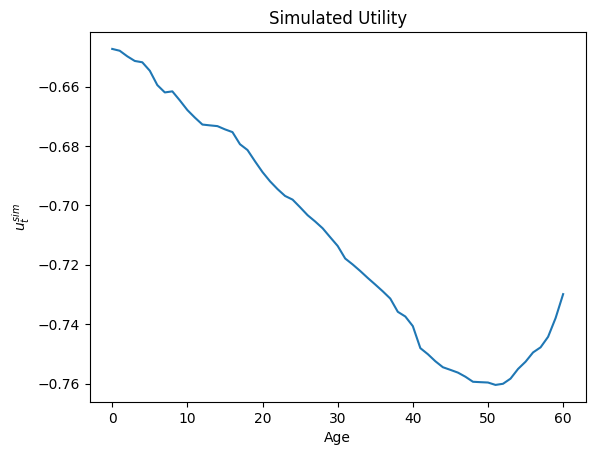

In [7]:
"""

run_slcm.py
-----------
This code solves the stochastic life cycle model using value function iteration.

"""

#%% Stochastic Growth Model.
some_dude = household()

# Set the parameters, state space, and utility function.
some_dude.setup(beta = 0.96,gamma=2.00) # You can set the parameters here or use the defaults.

# Solve the model.
experience_life(some_dude) # Obtain the policy functions for consumption and savings.

# Simulate the model.
grow_old_and_die(some_dude) # Simulate forward in time.

# Graphs.
track_aging(some_dude) # Plot policy functions and simulations.


--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the stochastic life cycle model and is solved via Backward Induction.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is fintely-lived and dies after T periods.
   It derives utility from consumption.
    -> He/she retires after tr periods.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.94
gamma:  2.0
amin:  0.0
amax:  30.0
kappa:  0.6

--------------------------------------------------------------------------------------------------
Solving the Model by Bac

<ipython-input-5-6d21752bfe8c>:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  csim[j,i] = cpol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Consumption in period t.
<ipython-input-5-6d21752bfe8c>:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asim[j,i] = apol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Savings for period t+1.
<ipython-input-5-6d21752bfe8c>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ysim[j,i] = kappa*yr[i]


Simulation done.

--------------------------------------------------------------------------------------------------



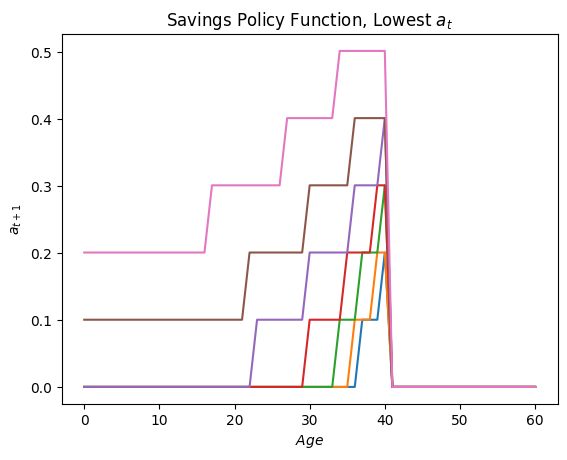

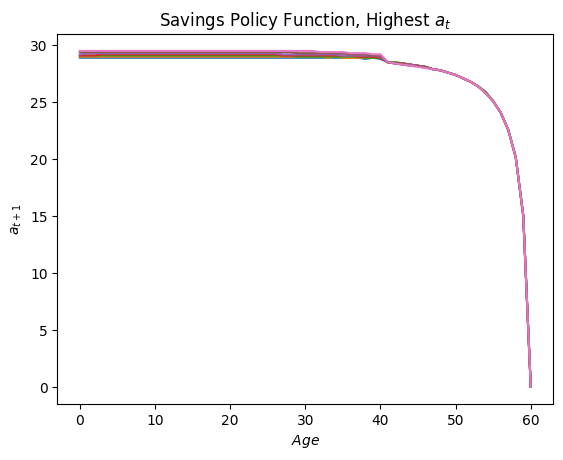

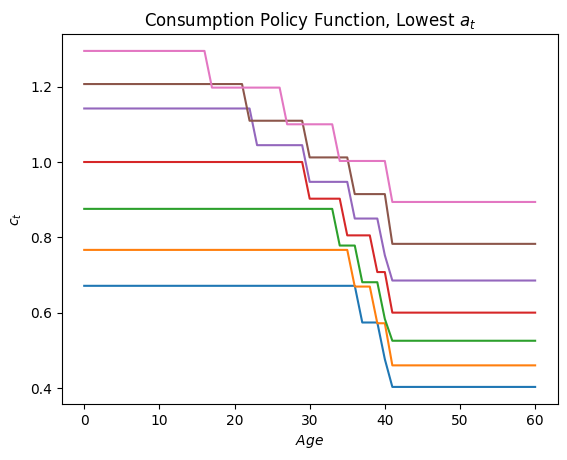

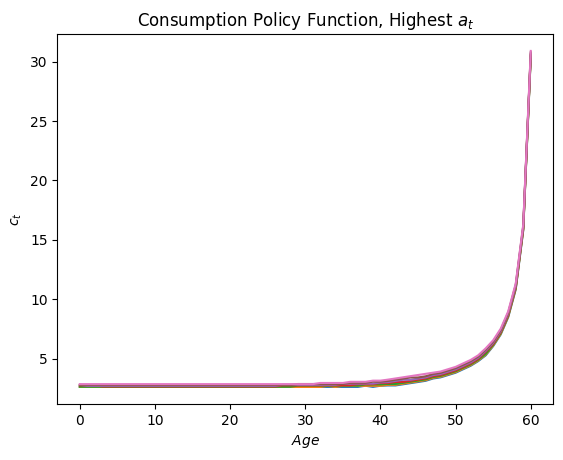

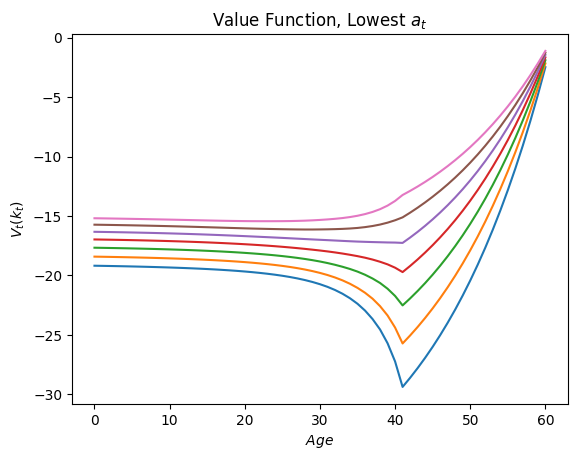

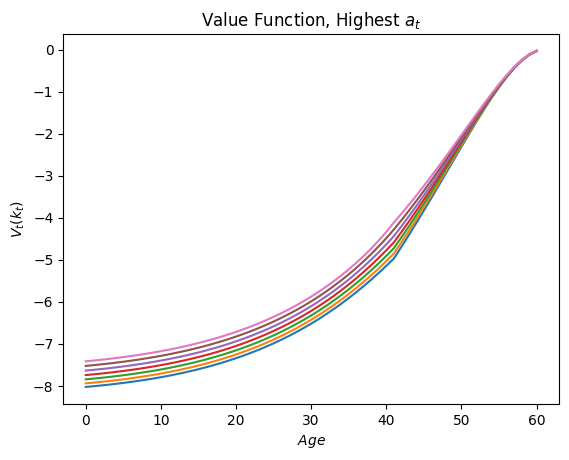

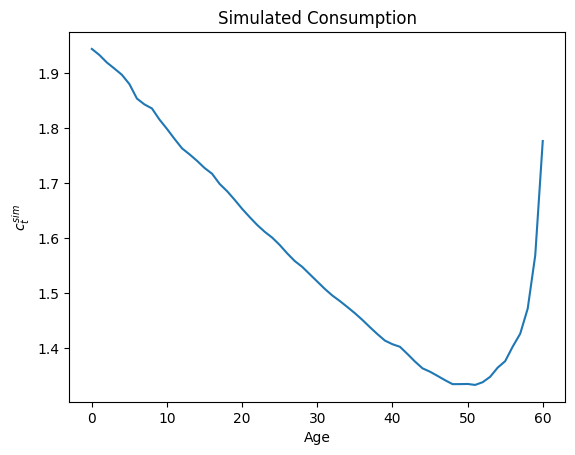

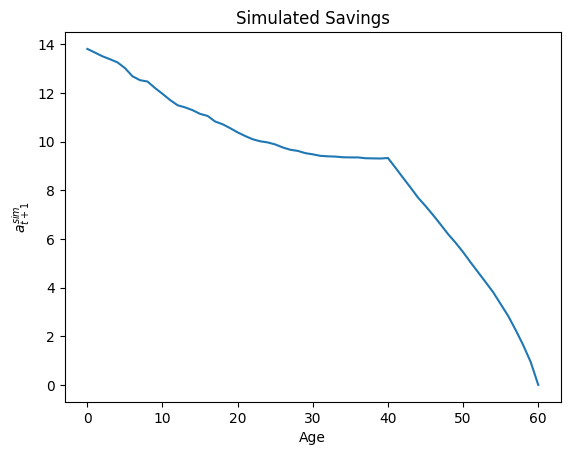

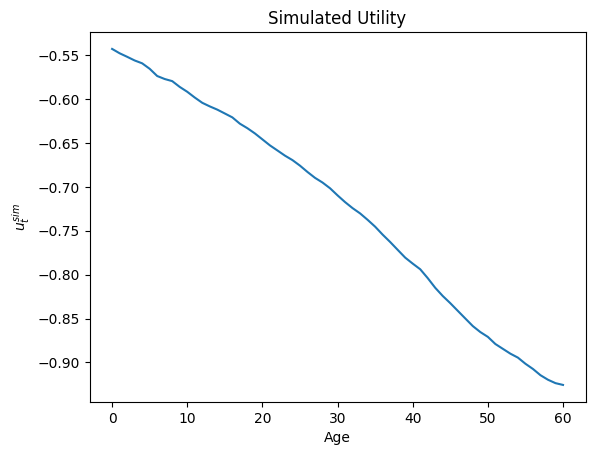

In [8]:
# Simulate the model.
some_dude = household()

# Set the parameters, state space, and utility function.
# Set beta and gamma as requested
some_dude.setup(beta=0.94, gamma=2.00, seed_sim=3000)
# Solve the model.
experience_life(some_dude) # Obtain the policy functions for consumption and savings.

# Simulate the model.
grow_old_and_die(some_dude) # Simulate forward in time.

# Graphs.
track_aging(some_dude) # Plot policy functions and simulations.

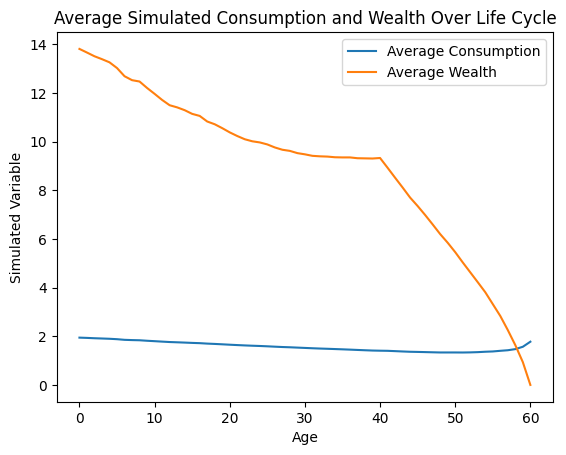

In [9]:
from matplotlib.pyplot import legend

# The age array is already generated in track_aging:
age = linspace(0,some_dude.par.T,some_dude.par.T,endpoint=False,dtype=int)

# The averaged simulated consumption and wealth are stored in:
lcp_c = zeros((some_dude.par.T,1))
lcp_a = zeros((some_dude.par.T,1))
lcp_u = zeros((some_dude.par.T,1))

from numpy import isnan # Import isnan here

for i in range(some_dude.par.T):
    valid_indices = ~isnan(some_dude.sim.tsim) & (some_dude.sim.tsim == i)

    if valid_indices.any(): # Only compute mean if there are valid data points for this age
        lcp_c[i] = nanmean(some_dude.sim.csim[valid_indices])
        lcp_a[i] = nanmean(some_dude.sim.asim[valid_indices])
        lcp_u[i] = nanmean(some_dude.sim.usim[valid_indices])
    else:
        # If no data points for this age (can happen if NN < T), set to NaN or some indicator
        lcp_c[i] = nan
        lcp_a[i] = nan
        lcp_u[i] = nan


# Plot average simulated consumption and wealth.
figure(10)
plot(age, lcp_c, label='Average Consumption')
plot(age, lcp_a, label='Average Wealth')
xlabel('Age')
ylabel('Simulated Variable')
title('Average Simulated Consumption and Wealth Over Life Cycle')
legend()
show()


Simulating with beta = 0.9 and gamma = 2.0
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the stochastic life cycle model and is solved via Backward Induction.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is fintely-lived and dies after T periods.
   It derives utility from consumption.
    -> He/she retires after tr periods.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.9
gamma:  2.0
amin:  0.0
amax:  30.0
kappa:  0.6

--------------------------------------------------------------------------------

<ipython-input-5-6d21752bfe8c>:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  csim[j,i] = cpol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Consumption in period t.
<ipython-input-5-6d21752bfe8c>:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asim[j,i] = apol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Savings for period t+1.
<ipython-input-5-6d21752bfe8c>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ysim[j,i] = kappa*yr[i]


Simulation done.

--------------------------------------------------------------------------------------------------


Simulating with beta = 0.92 and gamma = 2.0
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the stochastic life cycle model and is solved via Backward Induction.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is fintely-lived and dies after T periods.
   It derives utility from consumption.
    -> He/she retires after tr periods.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.92
gamma:  

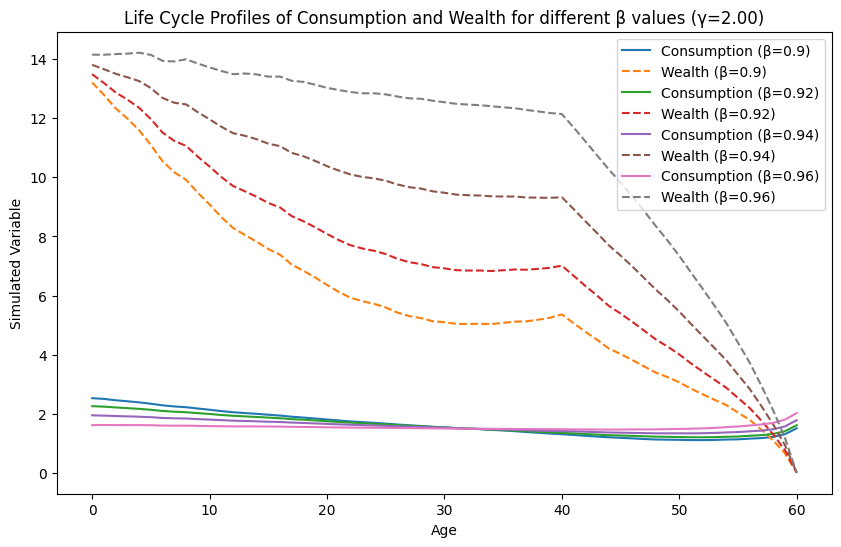

In [10]:
age = linspace(0, some_dude.par.T, some_dude.par.T, endpoint=False, dtype=int)

# Define the range of beta values and the fixed gamma value
beta_values = [0.90, 0.92, 0.94, 0.96]
gamma_value = 2.00

figure(figsize=(10, 6))

for beta in beta_values:
    print(f'\nSimulating with beta = {beta} and gamma = {gamma_value}')

    # Create a new household instance for each parameter combination
    current_dude = household()

    # Set the parameters for the current simulation
    current_dude.setup(beta=beta, gamma=gamma_value, seed_sim=3000)

    # Solve the model.
    experience_life(current_dude)

    # Simulate the model.
    grow_old_and_die(current_dude)

    # Calculate the average simulated consumption and wealth for each age.
    lcp_c = zeros((current_dude.par.T, 1))
    lcp_a = zeros((current_dude.par.T, 1))

    for i in range(current_dude.par.T):
        valid_indices = ~isnan(current_dude.sim.tsim) & (current_dude.sim.tsim == i)

        if valid_indices.any():
            lcp_c[i] = nanmean(current_dude.sim.csim[valid_indices])
            lcp_a[i] = nanmean(current_dude.sim.asim[valid_indices])
        else:
            lcp_c[i] = nan
            lcp_a[i] = nan

    # Plot the life cycle profiles of consumption and wealth on the same graph
    plot(age, lcp_c, label=f'Consumption (β={beta})')
    plot(age, lcp_a, label=f'Wealth (β={beta})', linestyle='--')

xlabel('Age')
ylabel('Simulated Variable')
title('Life Cycle Profiles of Consumption and Wealth for different β values (γ=2.00)')
legend()
show()


Simulating with beta = 0.96 and gamma = 2.0
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the stochastic life cycle model and is solved via Backward Induction.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is fintely-lived and dies after T periods.
   It derives utility from consumption.
    -> He/she retires after tr periods.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
gamma:  2.0
amin:  0.0
amax:  30.0
kappa:  0.6

------------------------------------------------------------------------------

<ipython-input-5-6d21752bfe8c>:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  csim[j,i] = cpol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Consumption in period t.
<ipython-input-5-6d21752bfe8c>:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asim[j,i] = apol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Savings for period t+1.
<ipython-input-5-6d21752bfe8c>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ysim[j,i] = kappa*yr[i]


Simulation done.

--------------------------------------------------------------------------------------------------


Simulating with beta = 0.96 and gamma = 3.0
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the stochastic life cycle model and is solved via Backward Induction.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is fintely-lived and dies after T periods.
   It derives utility from consumption.
    -> He/she retires after tr periods.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
gamma:  

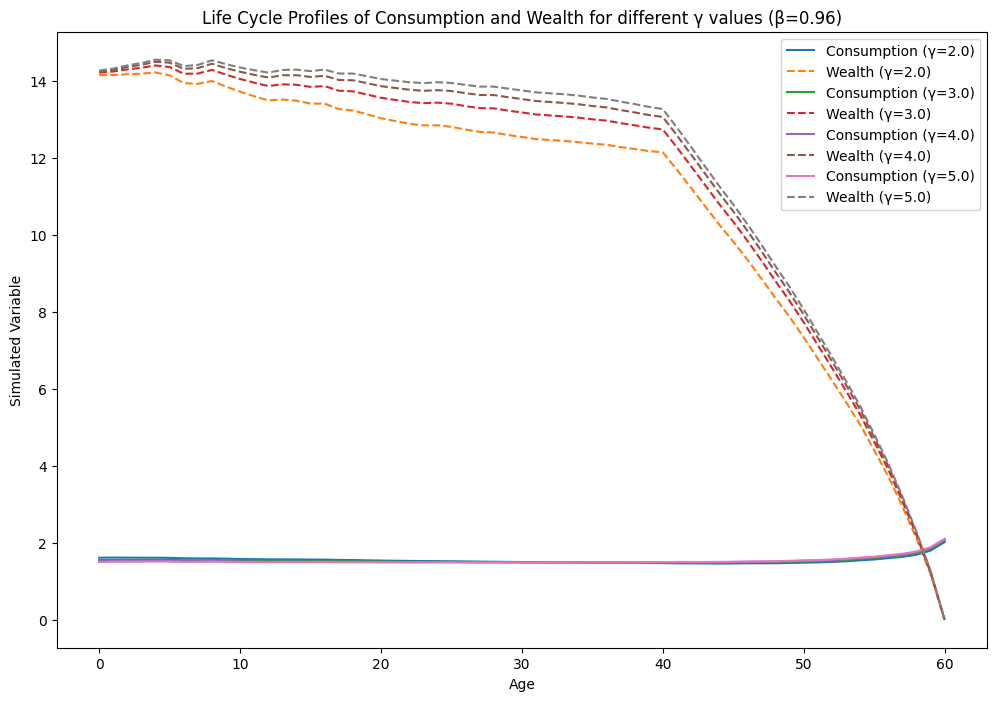

In [11]:
# Define the range of gamma values and the fixed beta value
gamma_values = [2.00, 3.00, 4.00, 5.00]
beta_value = 0.96

figure(figsize=(12, 8)) # Create a new figure for the combined plots

for gamma in gamma_values:
    print(f'\nSimulating with beta = {beta_value} and gamma = {gamma}')

    # Create a new household instance for each parameter combination
    current_dude = household()

    # Set the parameters for the current simulation
    current_dude.setup(beta=beta_value, gamma=gamma, seed_sim=3000)

    # Solve the model.
    experience_life(current_dude)

    # Simulate the model.
    grow_old_and_die(current_dude)

    # Calculate the average simulated consumption and wealth for each age.
    lcp_c = zeros((current_dude.par.T, 1))
    lcp_a = zeros((current_dude.par.T, 1))

    for i in range(current_dude.par.T):
        valid_indices = ~isnan(current_dude.sim.tsim) & (current_dude.sim.tsim == i)

        if valid_indices.any():
            lcp_c[i] = nanmean(current_dude.sim.csim[valid_indices])
            lcp_a[i] = nanmean(current_dude.sim.asim[valid_indices])
        else:
            lcp_c[i] = nan
            lcp_a[i] = nan

    # Plot the life cycle profiles of consumption and wealth on the same graph
    plot(age, lcp_c, label=f'Consumption (γ={gamma})')
    plot(age, lcp_a, label=f'Wealth (γ={gamma})', linestyle='--')

xlabel('Age')
ylabel('Simulated Variable')
title('Life Cycle Profiles of Consumption and Wealth for different γ values (β=0.96)')
legend()
show()


--------------------------------------------------------------------------------
Computing Average Wealth for Heatmap
--------------------------------------------------------------------------------

Simulating with gamma = 2.00 and beta = 0.90
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the stochastic life cycle model and is solved via Backward Induction.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is fintely-lived and dies after T periods.
   It derives utility from consumption.
    -> He/she retires after tr periods.

--------------------------------------------------------------------------------
Parameters:
--------------------

<ipython-input-5-6d21752bfe8c>:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  csim[j,i] = cpol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Consumption in period t.
<ipython-input-5-6d21752bfe8c>:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asim[j,i] = apol[at_ind,int(tsim[j,i]),int(y0_ind[i])] # Savings for period t+1.
<ipython-input-5-6d21752bfe8c>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ysim[j,i] = kappa*yr[i]


Simulation done.

--------------------------------------------------------------------------------------------------

  Average simulated wealth: 4.2321

Simulating with gamma = 2.00 and beta = 0.92
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the stochastic life cycle model and is solved via Backward Induction.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is fintely-lived and dies after T periods.
   It derives utility from consumption.
    -> He/she retires after tr periods.

--------------------------------------------------------------------------------
Parameters:
------------------------------------------------------------------

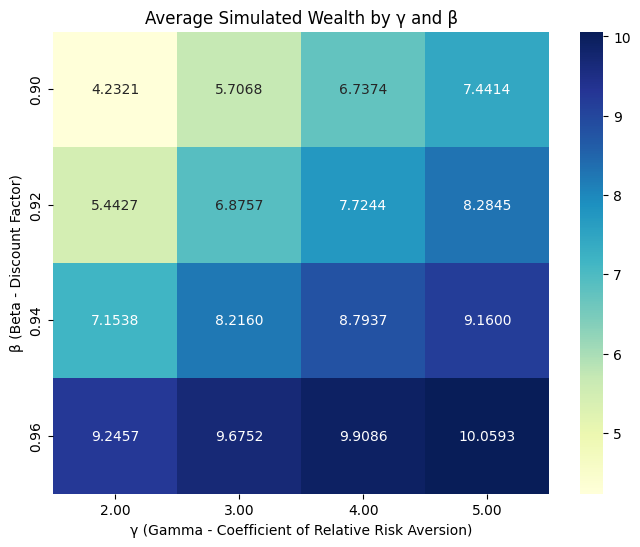

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define the ranges for gamma and beta
gamma_values = [2.00, 3.00, 4.00, 5.00]
beta_values = [0.90, 0.92, 0.94, 0.96]

# Create a dictionary to store average simulated wealth for each (gamma, beta) combination
average_wealth_data = {}

print('--------------------------------------------------------------------------------')
print('Computing Average Wealth for Heatmap')
print('--------------------------------------------------------------------------------\n')

for gamma in gamma_values:
    average_wealth_data[gamma] = {}
    for beta in beta_values:
        print(f'Simulating with gamma = {gamma:.2f} and beta = {beta:.2f}')

        # Create a new household instance
        current_dude = household()

        # Set the parameters for the current simulation
        current_dude.setup(beta=beta, gamma=gamma, seed_sim=3000)

        # Solve the model.
        experience_life(current_dude)

        # Simulate the model.
        grow_old_and_die(current_dude)

        # Calculate the average simulated wealth across all ages and individuals
        # We take the mean of the entire asim array, ignoring NaN values
        average_wealth = nanmean(current_dude.sim.asim)

        average_wealth_data[gamma][beta] = average_wealth

        print(f'  Average simulated wealth: {average_wealth:.4f}\n')

# Prepare data for the heatmap
# The x-axis will be gamma, y-axis will be beta
heatmap_data = np.zeros((len(beta_values), len(gamma_values)))

for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        heatmap_data[i, j] = average_wealth_data[gamma][beta]

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu",
            xticklabels=[f'{g:.2f}' for g in gamma_values],
            yticklabels=[f'{b:.2f}' for b in beta_values])

plt.xlabel('γ (Gamma - Coefficient of Relative Risk Aversion)')
plt.ylabel('β (Beta - Discount Factor)')
plt.title('Average Simulated Wealth by γ and β')
plt.show()



**2. Firm Investment Model**

In [ ]:
"""

model.py
--------
This code sets up the model.

"""

#%% Imports from Python
from numpy import count_nonzero,exp,expand_dims,linspace,tile
from scipy import stats
from types import SimpleNamespace

#%% Firm Investment Model.
class firm():
    '''

    Methods:
        __init__(self,**kwargs) -> Set the firm's attributes.
        setup(self,**kwargs) -> Sets parameters.

    '''

    #%% Constructor.
    def __init__(self,**kwargs):
        '''

        This initializes the model.

        Optional kwargs:
            All parameters changed by setting kwarg.

        '''

        print('--------------------------------------------------------------------------------------------------')
        print('Model')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The model is a dynamic model of firm investment and is solved via Value Function Iteration.')

        print('\n--------------------------------------------------------------------------------------------------')
        print('Household')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The firm is infintely-lived.')
        print('   It chooses investment to maximize profit.')

    #%% Set up model.
    def setup(self,**kwargs):
        '''

        This sets the parameters and creates the grids for the model.

            Input:
                self : Model class.
                kwargs : Values for parameters if not using the default.

        '''

        # Namespace for parameters, grids, and utility function.
        setattr(self,'par',SimpleNamespace())
        par = self.par

        print('\n--------------------------------------------------------------------------------')
        print('Parameters:')
        print('--------------------------------------------------------------------------------\n')

        # Technology.
        par.beta = 0.96 # Discount factor.
        par.alpha = 2.0 # Capital's share of income.
        par.delta = 0.5 # Depreciation rate.
        par.w = 1.0

        # Prices and Income.
        par.p = 1.0 # Price of investment.
        par.gamma = 1.0 # Speed of adjustment; cost function coefficient.

        par.sigma_eps_A = 0.07 # Std. dev of productivity shocks.
        par.sigma_eps_p = 0.05 # Std. dev of productivity shocks.
        par.rho_A = 0.85 # Persistence of AR(1) process.
        par.rho_p = 0.75 # Persistence of AR(2) process.

        par.mu_A = 0.0 # Intercept of AR(1) process.
        par.mu_p = 0.0 # Intercept of AR(2) process.

        par.ylen = 7 # Grid size for y.
        par.m = 3 # Scaling parameter for Tauchen.

        # Simulation parameters.
        par.seed_sim = 2025 # Seed for simulation.
        par.T = 1000 # Number of time periods.

        # Set up asset grid.
        par.klen = 300 # Grid size for k.
        par.kmax = 30.0 # Upper bound for k.
        par.kmin = 0.0001 # Minimum k.

        # Set up variable input (x) grid:
        par.xlen = 30 # Grid size for x
        par.xmax = 20.0
        par.xmin = 0.01

        # Discretized productivity.

        par.Alen = 7 # Grid size for A.
        par.m = 3 # Scaling parameter for Tauchen.

        par.plen = 7
        pgrid_log, pmat_p = tauchen(0.0, par.rho_p, par.sigma_eps_p, par.plen, par.m)
        par.pgrid = exp(pgrid_log)
        par.pmat_p = pmat_p

        # Update parameter values to kwarg values if you don't want the default values.
        for key,val in kwargs.items():
            setattr(par,key,val)

        assert par.beta > 0.0 and par.beta < 1.0
        assert par.alpha > 0.0 and par.alpha < 1.0
        assert par.delta >= 0.0 and par.delta <= 1.0
        assert par.sigma_eps_A > 0.00 and par.sigma_eps_p > 0.00
        assert abs(par.sigma_eps_A) < 1.00 and abs(par.sigma_eps_p) < 1.00
        assert par.p > 0.0
        assert par.gamma >= 0.0
        assert par.klen > 5
        assert par.kmax > par.kmin

        # Set up asset grid.
        par.kgrid = linspace(par.kmin,par.kmax,par.klen) # Equally spaced, linear grid for k (and k').
        par.xgrid = linspace(par.xmin, par.xmax, par.xlen)

        # Discretize productivity.
        Agrid,pmat = tauchen(par.mu_A,par.rho_A,par.sigma_eps_A,par.Alen,par.m) # Tauchen's Method to discretize the AR(1) process for log productivity.
        par.Agrid = exp(Agrid) # The AR(1) is in logs so exponentiate it to get A.
        par.pmat = pmat # Transition matrix.

        # Revenue and cost functions.
        par.production = production
        par.total_cost = total_cost

        print('beta: ',par.beta)
        print('alpha: ',par.alpha)
        print('delta: ',par.delta)
        print('kmin: ',par.kmin)
        print('kmax: ',par.kmax)
        print('gamma: ',par.gamma)

#%% Revenue Function.
def production(A,k,x, alpha):
    #Revenue function.

    output = A * (k ** alpha) * (x ** (1.0 - alpha)) # Cobb-Douglas production.

    return output

#%% Cost function.

def total_cost(k,p,kgrid,delta,gamma):
    # Convex adjustment cost.

    invest = kgrid-(1.0-delta)*k
    adj_cost = (gamma/2.0)*((invest/k)**2.0)*k # Convex adjustment cost.
    cost = adj_cost + p*invest # Total investment cost.

    return cost


#%% Tauchen's Method.
def tauchen(mu,rho,sigma,N,m):
    """

    This function discretizes an AR(1) process.

            y(t) = mu + rho*y(t-1) + eps(t), eps(t) ~ NID(0,sigma^2)

    Input:
        mu    : Intercept of AR(1).
        rho   : Persistence of AR(1).
        sigma : Standard deviation of error term.
        N     : Number of states.
        m     : Parameter such that m time the unconditional std. dev. of the AR(1) is equal to the largest grid point.

    Output:
        y    : Grid for the AR(1) process.
        pmat : Transition probability matrix.

    """

    #%% Construct equally spaced grid.

    ar_mean = mu/(1.0-rho) # The mean of a stationary AR(1) process is mu/(1-rho).
    ar_sd = sigma/((1.0-rho**2.0)**(1/2)) # The std. dev of a stationary AR(1) process is sigma/sqrt(1-rho^2)

    y1 = ar_mean-(m*ar_sd) # Smallest grid point is the mean of the AR(1) process minus m*std.dev of AR(1) process.
    yn = ar_mean+(m*ar_sd) # Largest grid point is the mean of the AR(1) process plus m*std.dev of AR(1) process.

    y,d = linspace(y1,yn,N,endpoint=True,retstep=True) # Equally spaced grid. Include endpoint (endpoint=True) and record stepsize, d (retstep=True).

    #%% Compute transition probability matrix from state j (row) to k (column).

    ymatk = tile(expand_dims(y,axis=0),(N,1)) # Container for state next period.
    ymatj = mu+rho*ymatk.T # States this period.

    # In the following, loc and scale are the mean and std used to standardize the variable. # For example, norm.cdf(x,loc=y,scale=s) is the standard normal CDF evaluated at (x-y)/s.
    pmat = stats.norm.cdf(ymatk,loc=ymatj-(d/2.0),scale=sigma)-stats.norm.cdf(ymatk,loc=ymatj+(d/2.0),scale=sigma) # Transition probabilities to state 2, ..., N-1.
    pmat[:,0] = stats.norm.cdf(y[0],loc=mu+rho*y-(d/2.0),scale=sigma) # Transition probabilities to state 1.
    pmat[:,N-1] = 1.0-stats.norm.cdf(y[N-1],loc=mu+rho*y+(d/2.0),scale=sigma) # Transition probabilities to state N.

    #%% Output.

    y = expand_dims(y,axis=0) # Convert 0-dimensional array to a row vector.

    if count_nonzero(pmat.sum(axis=1)<0.999999) > 0:
        raise Exception("Some columns of transition matrix don't sum to 1.")

    return y,pmat

In [ ]:
"""

solve.py
--------
This code solves the model.

"""

#%% Imports from Python
from numpy import argmax,squeeze,zeros,seterr
from numpy.linalg import norm
from types import SimpleNamespace
import time
seterr(divide='ignore')
seterr(invalid='ignore')

#%% Solve the model using Value Function Iteration.
def do_business(myClass):
    '''

    This function solves the dynamic model of firm investment.

    Input:
        myClass : Model class with parameters, grids, cost function, and profit function.

    '''

    print('\n--------------------------------------------------------------------------------------------------')
    print('Solving the Model by Value Function Iteration')
    print('--------------------------------------------------------------------------------------------------\n')

    # Namespace for optimal policy funtions.
    setattr(myClass,'sol',SimpleNamespace())
    sol = myClass.sol

    # Model parameters, grids and functions.

    par = myClass.par # Parameters.

    beta = par.beta # Discount factor.
    alpha = par.alpha # Capital's share of income.
    delta = par.delta # Depreciation rate
    gamma = par.gamma # Speed of adjustment; cost function coefficient.

    p = par.p # Price of investing in capital.

    klen = par.klen # Grid size for k.
    kgrid = par.kgrid # Grid for k (state and choice).

    Alen = par.Alen # Grid size for A.
    Agrid = par.Agrid[0] # Grid for A.
    pmat = par.pmat # Grid for A.

    # xgrid for the labor input
    xgrid = par.xgrid

    production = par.production # Revenue function.
    total_cost = par.total_cost # Cost function.

    # Value Function Iteration.
    v0 = zeros((klen,Alen)) # Guess of value function for each value of k.

    crit = 1e-6;
    maxiter = 10000;
    diff = 1;
    iter = 0;

    t0 = time.time()

    while (diff > crit) and (iter < maxiter): # Iterate on the Bellman Equation until convergence.

        v1 = zeros((klen,Alen)) # Container for V.
        k1 = zeros((klen,Alen)) # Container for k'.
        i1 = zeros((klen,Alen)) # Container for i.
        r1 = zeros((klen,Alen)) # Container for revenue.
        e1 = zeros((klen,Alen)) # Container for investment expenditure.
        p1 = zeros((klen,Alen)) # Container for profit.

        for q in range(0,klen): # Loop over the k-states.
            for j in range(0,Alen): # Loop over the A-states.

                # Macro variables.
                rev = production(Agrid[j],kgrid[q],xgrid[0], alpha) # Revenue given A and K.
                expend = total_cost(kgrid[q],p,kgrid,delta,gamma) # Total investment expenditure given K.
                prof = rev-expend # Profit.
                invest = kgrid-(1.0-delta)*kgrid[q] # Investment in new capital.

                # Solve the maximization problem.
                ev = squeeze(v0@pmat[j,:].T); #  The next-period value function is the expected value function over each possible next-period A, conditional on the current state j.
                vall = prof + beta*ev # Compute the value function for each choice of k', given k.
                v1[q,j] = max(vall) # Maximize: vmax is the maximized value function; ind is where it is in the grid.
                k1[q,j] = kgrid[argmax(vall)] # Optimal k'.
                i1[q,j] = invest[argmax(vall)] # Optimal i.
                r1[q,j] = rev # Total revenue.
                e1[q,j] = expend[argmax(vall)] # Total cost.
                p1[q,j] = prof[argmax(vall)] # Profits.

        diff = norm(v1-v0) # Check convergence.
        v0 = v1; # Update guess.

        iter = iter + 1; # Update counter.

        # Print counter.
        if iter%25 == 0:
            print('Iteration: ',iter,'.\n')

    t1 = time.time()
    print('Elapsed time is ',t1-t0,' seconds.')
    print('Converged in ',iter,' iterations.')

    # Macro variables, value, and policy functions.
    sol.v = v1 # Firm value.
    sol.k = k1 # Capital policy function.
    sol.i = i1 # Investment policy function.
    sol.r = r1 # Revenue function.
    sol.e = e1 # Investment expenditure function.
    sol.p = p1 # Profit function.

In [ ]:
"""

simulate.py
-----------
This code simulates the model.

"""

#%% Imports from Python
from numpy import cumsum,empty,linspace,nan,squeeze,where,zeros
from numpy.random import choice,rand,seed
from numpy.linalg import matrix_power
from types import SimpleNamespace

#%% Simulate the model.
def earn_profit(myClass):
    '''

    This function simulates the dynamic model of firm investment.

    Input:
        myClass : Model class with parameters, grids, cost and revenue functions, and policy functions.

    '''

    print('\n--------------------------------------------------------------------------------------------------')
    print('Simulate the Model')
    print('--------------------------------------------------------------------------------------------------\n')

    # Namespace for simulation.
    setattr(myClass,'sim',SimpleNamespace())
    sim = myClass.sim

    # Model parameters, grids and functions.

    par = myClass.par # Parameters.
    sol = myClass.sol # Policy functions.

    par.seed_sim # Seed for simulation.

    klen = par.klen # Capital grid size.
    Alen = par.Alen # Productivity grid size.
    kgrid = par.kgrid # Capital today (state).
    Agrid = par.Agrid[0] # Productivity today (state).
    pmat = par.pmat # Productivity today (state).

    vpol = sol.v # Firm value.
    kpol = sol.k # Policy function for capital.
    ipol = sol.i # Policy function for investment.
    rpol = sol.r # Optimal revenue.
    epol = sol.e # Optimal total investment expenditure.
    ppol = sol.p # Optimal profit.

    T = par.T # Time periods.
    Asim = zeros((T*2,1)) # Container for simulated productivity.
    vsim = zeros((T*2,1)) # Container for simulated firm value.
    rsim = zeros((T*2,1)) # Container for simulated output.
    ksim = zeros((T*2,1)) # Container for simulated capital stock.
    isim = zeros((T*2,1)) # Container for simulated investment.
    esim = zeros((T*2,1)) # Container for simulated investment expenditure.
    psim = zeros((T*2,1)) # Container for simulated profit.

    # Begin simulation.

    seed(par.seed_sim)

    pmat0 = matrix_power(pmat,1000)
    pmat0 = pmat0[0,:] # % Stationary distribution.
    cmat = cumsum(par.pmat,axis=1) # CDF matrix.

    A0_ind = choice(linspace(0,Alen,Alen,endpoint=False,dtype=int),1,p=pmat0) # Index for initial productivity.
    k0_ind = choice(linspace(0,klen,klen,endpoint=False,dtype=int),1) # Index for initial capital stock.

    Asim[0] = Agrid[A0_ind] # Productivity in period 1.
    vsim[0] = vpol[k0_ind,A0_ind] # Firm value in period 1 given k0 and A0.
    ksim[0] = kpol[k0_ind,A0_ind] # Capital choice for period 2 given k0 and A0.
    isim[0] = ipol[k0_ind,A0_ind] # Investment in period 1 given k0 and A0.
    rsim[0] = rpol[k0_ind,A0_ind] # Revenue in period 1 given k0 and A0.
    esim[0] = epol[k0_ind,A0_ind] # Investment ependiture in period 1 given k0 and A0.
    psim[0] = ppol[k0_ind,A0_ind] # Profit in period 1 given k0 and A0.

    A1_ind = where(rand(1)<=squeeze(cmat[A0_ind,:])) # Draw productivity for next period.
    At_ind = A1_ind[0][0]

    # Simulate endogenous variables.

    for j in range(1,T*2): # Time loop.
        kt_ind = where(ksim[j-1]==kgrid); # Capital choice in the previous period is the state today. Find where the latter is on the grid.
        Asim[j] = Agrid[At_ind] # Productivity in period t.
        vsim[j] = vpol[kt_ind,At_ind] # Firm value in period t.
        ksim[j] = kpol[kt_ind,At_ind] # Capital stock for period t+1.
        isim[j] = ipol[kt_ind,At_ind] # Investment in period t.
        rsim[j] = rpol[kt_ind,At_ind] # Revenue in period t.
        esim[j] = epol[kt_ind,At_ind] # Investment expenditure in period t.
        psim[j] = ppol[kt_ind,At_ind] # Profit in period t.
        A1_ind = where(rand(1)<=squeeze(cmat[At_ind,:])) # Draw next state.
        At_ind = A1_ind[0][0] # State next period.

    # Simulated model.
    sim.Asim = Asim[T:2*T] # Simulated productivity.
    sim.vsim = vsim[T:2*T] # Simulated firm value.
    sim.ksim = ksim[T:2*T] # Simulated capital choice.
    sim.isim = isim[T:2*T] # Simulated investment.
    sim.rsim = rsim[T:2*T] # Simulated revenue.
    sim.esim = esim[T:2*T] # Simulated investment expenditure.
    sim.psim = psim[T:2*T] # Simulated profit.

    print('Simulation done.\n')
    print('--------------------------------------------------------------------------------------------------\n')

In [ ]:
"""

my_graph.py
-----------
This code plots the value and policy functions.

"""

#%% Imports from Python
from matplotlib.pyplot import figure,plot,xlabel,ylabel,title,show
from numpy import linspace

#%% Plot the model functions and simulations.
def track_profit(myClass):
    '''

    This function plots the model functions and simulations.

    Input:
        myClass : Model class with parameters, grids, cost and revenue functions, policy functions, and simulations.

    '''

    # Model parameters, policy and value functions, and simulations.
    par = myClass.par # Parameters.
    sol = myClass.sol # Policy functions.
    sim = myClass.sim # Simulations.

    #Plot capital policy function.

    figure(1)
    plot(par.kgrid,sol.k)
    xlabel('$k_t$')
    ylabel('$k_{t+1}$')
    title('Capital Policy Function')

    # Plot investment policy function.

    figure(2)
    plot(par.kgrid,sol.i)
    xlabel('$k_t$')
    ylabel('$i_t$')
    title('Investment Policy Function')

    # Plot revenue function.

    figure(3)
    plot(par.kgrid,sol.r)
    xlabel('$k_t$')
    ylabel('$r_t$')
    title('Revenue Function')

    # Plot expenditure function.

    figure(4)
    plot(par.kgrid,sol.e)
    xlabel('$k_t$')
    ylabel('$C(k_{t+1},A_t,k_t)+pi_t$')
    title('Expenditure Function')

    # Plot profit function.

    figure(5)
    plot(par.kgrid,sol.p)
    xlabel('$k_t$')
    ylabel('$C(k_{t+1},A_t,k_t)+pi_t$')
    title('Profit Function')

    # Plot value function.

    figure(6)
    plot(par.kgrid,sol.v)
    xlabel('$k_t$')
    ylabel('$v_t$')
    title('Value Function')

    # Plot simulated revenue shocks.

    tgrid = linspace(1,par.T,par.T,dtype=int)

    figure(7)
    plot(tgrid,sim.Asim)
    xlabel('Time')
    ylabel('$A^sim_t$')
    title('Simulated Revenue Shocks')

    # Plot simulated capital choice.

    figure(8)
    plot(tgrid,sim.ksim)
    xlabel('Time')
    ylabel('$k^sim_t$')
    title('Simulated Capital Choice')

    # Plot simulated investment expenditure.

    figure(9)
    plot(tgrid,sim.esim)
    xlabel('Time')
    ylabel('$C(k^{sim}_{t+1},A^{sim}_t,k^{sim}_t)+pi^{sim}_t$')
    title('Simulated Investment Expenditure')

    # Plot simulated investment.

    figure(10)
    plot(tgrid,sim.isim)
    xlabel('Time')
    ylabel('$i^{sim}_t$')
    title('Simulated Investment')

    # Plot simulated revenue.

    figure(11)
    plot(tgrid,sim.rsim)
    xlabel('Time')
    ylabel('$y^{sim}_t$')
    title('Simulated Revenue')

    # Plot simulated profit.

    figure(12)
    plot(tgrid,sim.psim)
    xlabel('Time')
    ylabel('$\pi^{sim}_t$')
    title('Simulated Profit')

    # Plot simulated value function.

    figure(13)
    plot(tgrid,sim.vsim)
    xlabel('Time')
    ylabel('$v^{sim}_t$')
    title('Simulated Firm Value')

    #show()


--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is a dynamic model of firm investment and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The firm is infintely-lived.
   It chooses investment to maximize profit.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
alpha:  0.66
delta:  0.5
kmin:  0.0001
kmax:  30.0
gamma:  1.0

--------------------------------------------------------------------------------------------------
Solving the Model by Value Function Iteration
----------------

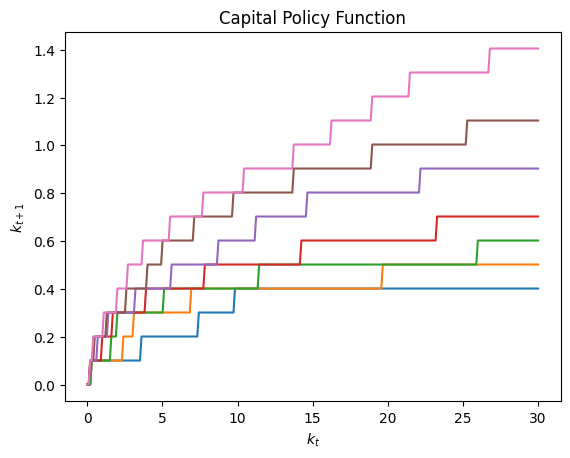

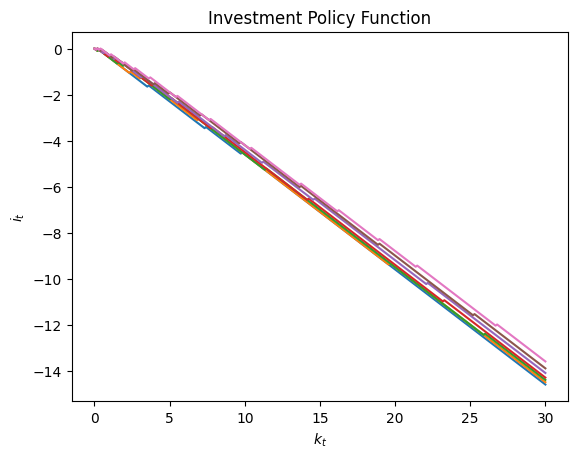

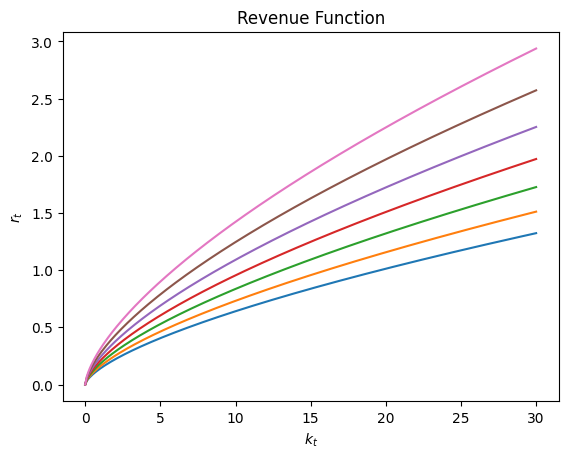

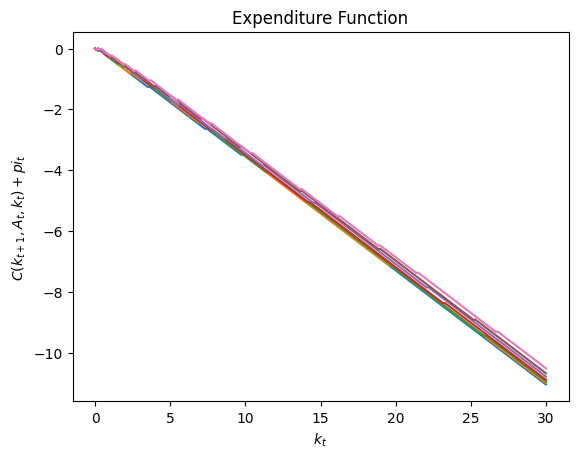

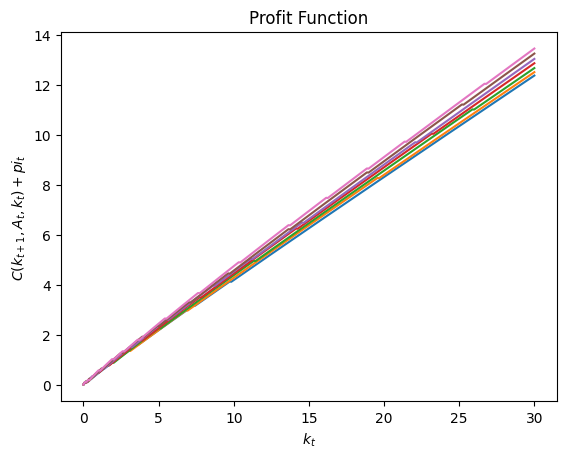

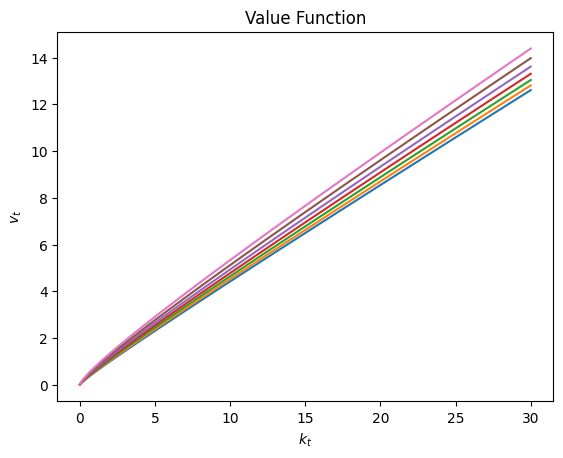

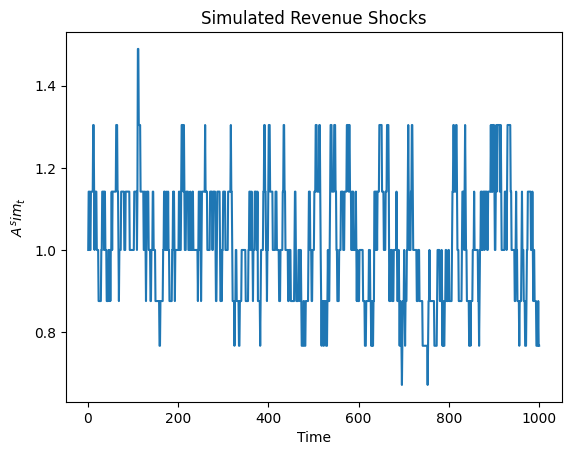

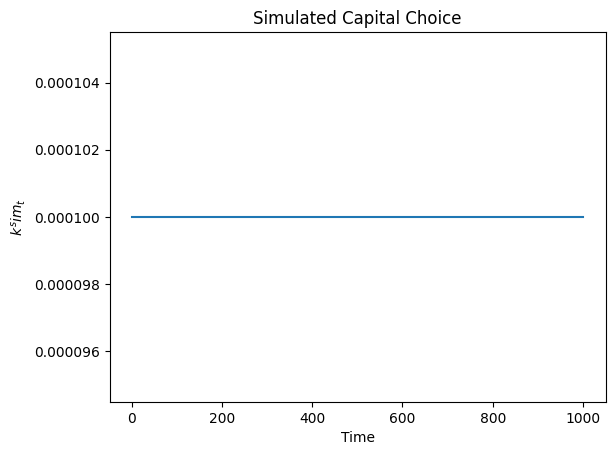

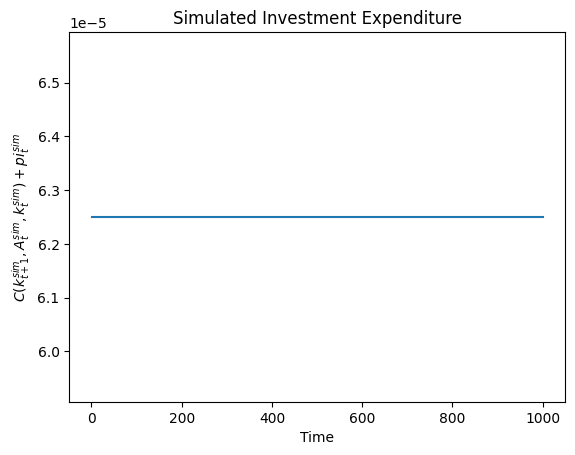

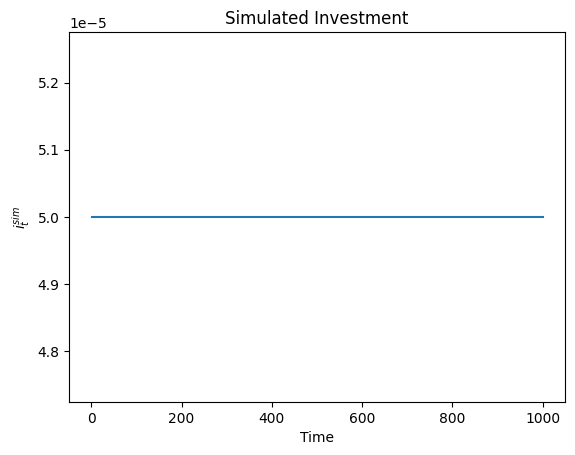

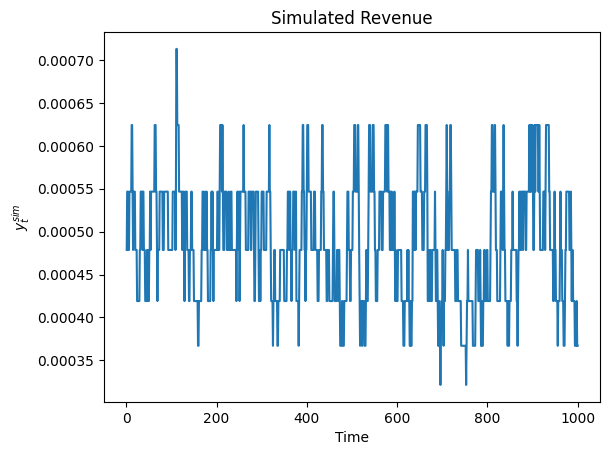

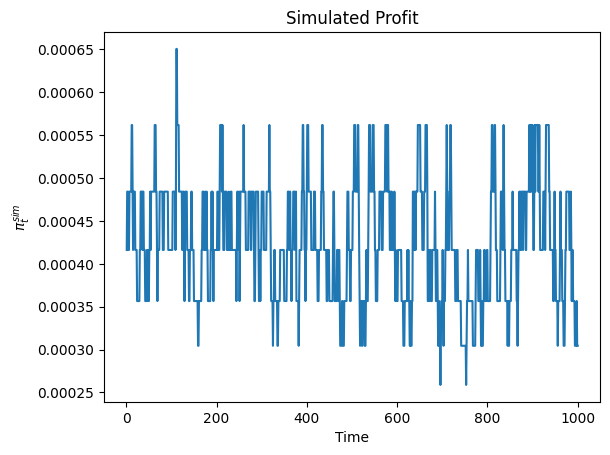

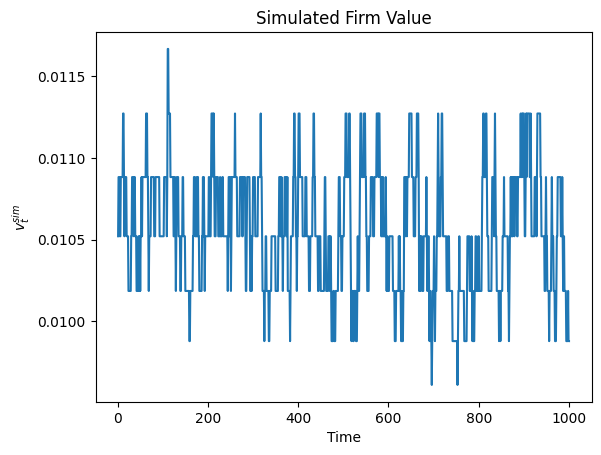

In [ ]:
"""

run_slcm.py
-----------
This code solves the dynamic model of firm investment using value function iteration.

"""

#%% Stochastic Growth Model.
some_company = firm()

# Set the parameters, state space, and utility function.
some_company.setup(beta = 0.96,alpha=0.66) # You can set the parameters here or use the defaults.

# Solve the model.
do_business(some_company) # Obtain the policy functions for consumption and savings.

# Simulate the model.
earn_profit(some_company) # Simulate forward in time.

# Graphs.
track_profit(some_company) # Plot policy functions and simulations.


**Spliting sample into small and large firms**

In [ ]:
import pandas as pd

# Load dataset with a different encoding since it can not be loaded directly
try:
    df = pd.read_csv('ES_Vietnam_2005_2009_2015.csv', encoding='latin-1')
except UnicodeDecodeError:
    print("Error decoding with latin-1. Trying another encoding...")
    try:
        df = pd.read_csv('ES_Vietnam_2005_2009_2015.csv', encoding='ISO-8859-1')
    except UnicodeDecodeError:
        print("Error decoding with ISO-8859-1. Trying cp1252...")
        try:
            df = pd.read_csv('ES_Vietnam_2005_2009_2015.csv', encoding='cp1252')
        except UnicodeDecodeError:
            print("Could not decode the file with common encodings. Please check the file encoding.")
            # You might need to use a different encoding or a tool to determine the correct encoding.

# Check the first few rows
print(df.head())

# 'l1' is the variable for number of employees
# Drop rows with missing 'l1' values
df = df.dropna(subset=['l1'])

# Calculate the median number of employees
median_employees = df['l1'].median()

print(f"Median number of employees: {median_employees}")

# Create a new column for firm size category
df['size_category'] = df['l1'].apply(lambda x: 'Large' if x >= median_employees else 'Small')

# Split the data into small and large firms
small_firms = df[df['size_category'] == 'Small']
large_firms = df[df['size_category'] == 'Large']

print(f"Number of small firms: {len(small_firms)}")
print(f"Number of large firms: {len(large_firms)}")

   idstd2015   id2015  idstd2009  id2009  idstd2005   id2005  year  panel  \
0   599613.0      NaN   466100.0     4.0    60775.0  10597.0  2005      6   
1   599613.0      NaN   466100.0     4.0    60775.0      NaN  2009      6   
2   599613.0  10697.0        NaN     NaN        NaN      NaN  2015      6   
3   599614.0      NaN   466101.0     6.0    60785.0  10619.0  2005      6   
4   599614.0      NaN   466101.0     6.0    60785.0      NaN  2009      6   

                                     eligibility2015  _2015_preference  ...  \
0  1. Eligible establishment (Correct name and ad...               NaN  ...   
1  1. Eligible establishment (Correct name and ad...               NaN  ...   
2                                                NaN               6.0  ...   
3  1. Eligible establishment (Correct name and ad...               NaN  ...   
4  1. Eligible establishment (Correct name and ad...               NaN  ...   

   _2005_q92b1  _2005_q92b2  _2005_q92b3  _2005_q92b4  _2005_q

<ipython-input-57-3748d9eaf481>:5: DtypeWarning: Columns (8,44,59,85,87,113,149,292,301,329,332,335,388,396,409,440,457,462,465,469,472,512,527,532,630,644,657,661,663,738) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ES_Vietnam_2005_2009_2015.csv', encoding='latin-1')


**Empirical Relationship between debt, production input, finance**


Empirical relationships for Small Firms:
          k11       n2e        d2
k11  1.000000 -0.019874 -0.024371
n2e -0.019874  1.000000  0.714864
d2  -0.024371  0.714864  1.000000

Empirical relationships for Large Firms:
          k11       n2e        d2
k11  1.000000  0.446485  0.468726
n2e  0.446485  1.000000  0.789470
d2   0.468726  0.789470  1.000000


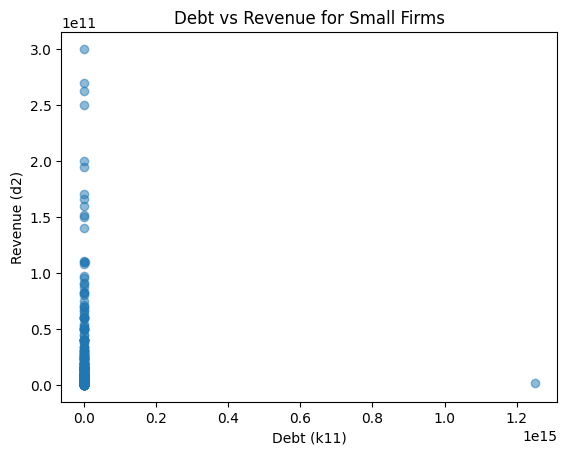

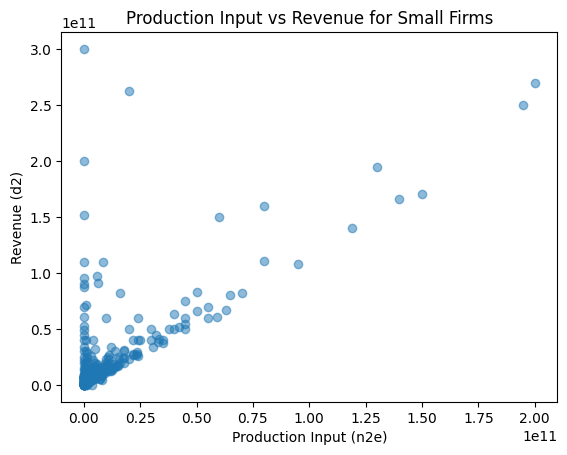

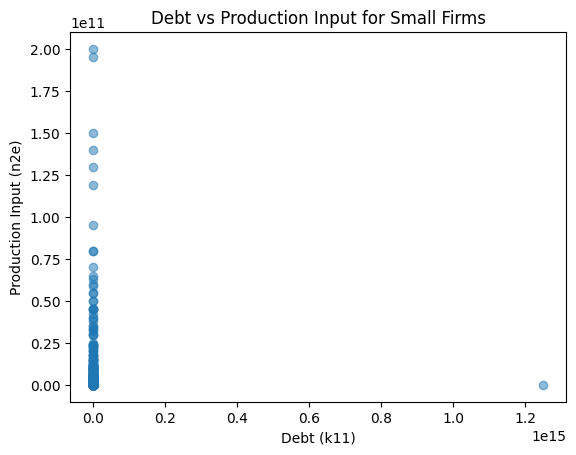

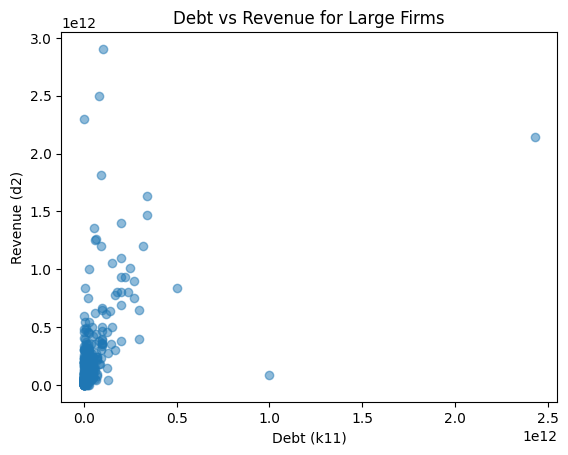

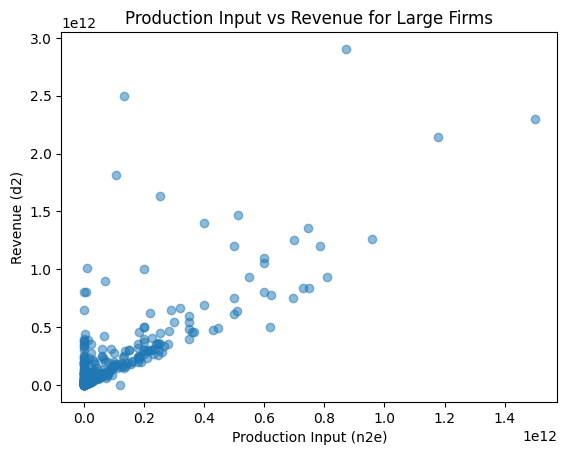

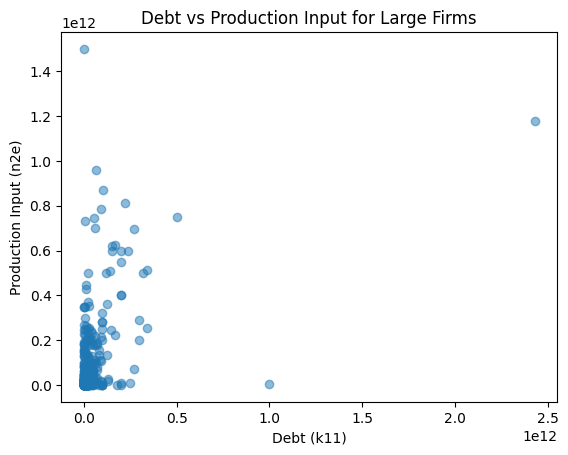

In [ ]:
# Select relevant columns for small and large firms
small_firms_subset = small_firms[['k11', 'n2e', 'd2']].dropna()
large_firms_subset = large_firms[['k11', 'n2e', 'd2']].dropna()

print("\nEmpirical relationships for Small Firms:")
print(small_firms_subset.corr())

print("\nEmpirical relationships for Large Firms:")
print(large_firms_subset.corr())

# Small firms
figure()
plot(small_firms_subset['k11'], small_firms_subset['d2'], 'o', alpha=0.5)
xlabel('Debt (k11)')
ylabel('Revenue (d2)')
title('Debt vs Revenue for Small Firms')
show()

figure()
plot(small_firms_subset['n2e'], small_firms_subset['d2'], 'o', alpha=0.5)
xlabel('Production Input (n2e)')
ylabel('Revenue (d2)')
title('Production Input vs Revenue for Small Firms')
show()

figure()
plot(small_firms_subset['k11'], small_firms_subset['n2e'], 'o', alpha=0.5)
xlabel('Debt (k11)')
ylabel('Production Input (n2e)')
title('Debt vs Production Input for Small Firms')
show()


# Large firms
figure()
plot(large_firms_subset['k11'], large_firms_subset['d2'], 'o', alpha=0.5)
xlabel('Debt (k11)')
ylabel('Revenue (d2)')
title('Debt vs Revenue for Large Firms')
show()

figure()
plot(large_firms_subset['n2e'], large_firms_subset['d2'], 'o', alpha=0.5)
xlabel('Production Input (n2e)')
ylabel('Revenue (d2)')
title('Production Input vs Revenue for Large Firms')
show()

figure()
plot(large_firms_subset['k11'], large_firms_subset['n2e'], 'o', alpha=0.5)
xlabel('Debt (k11)')
ylabel('Production Input (n2e)')
title('Debt vs Production Input for Large Firms')
show()


**Stimulate the model for small and large firms**


Simulating model for Small Firms:
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is a dynamic model of firm investment and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The firm is infintely-lived.
   It chooses investment to maximize profit.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.95
alpha:  0.6
delta:  0.6
kmin:  0.0001
kmax:  20.0
gamma:  1.5

--------------------------------------------------------------------------------------------------
Solving the Model by Value F

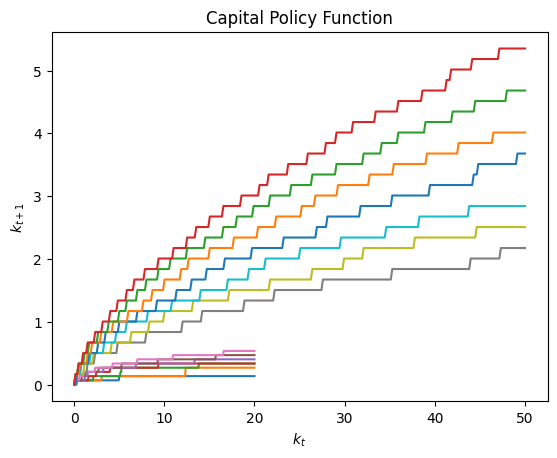

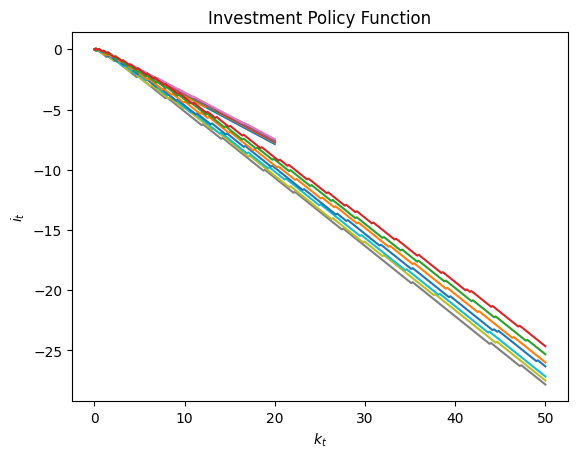

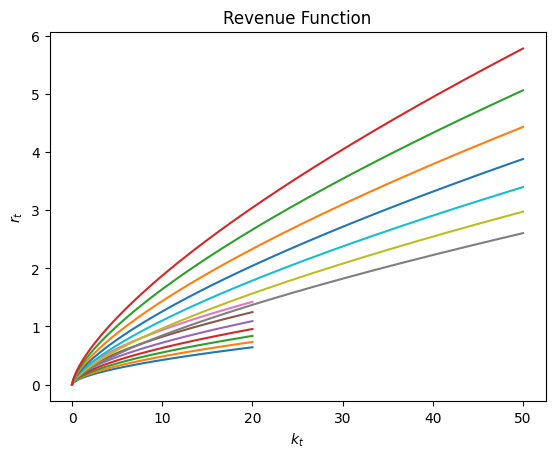

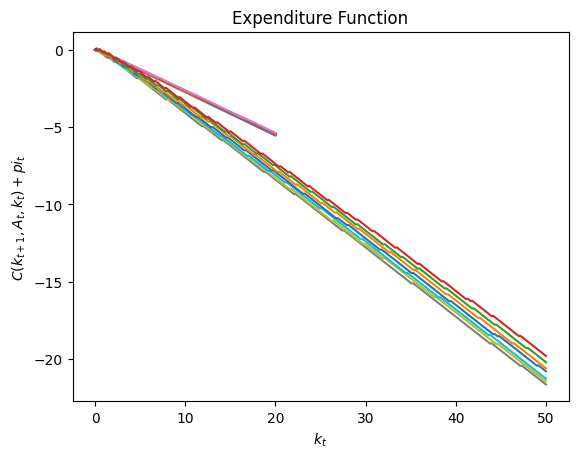

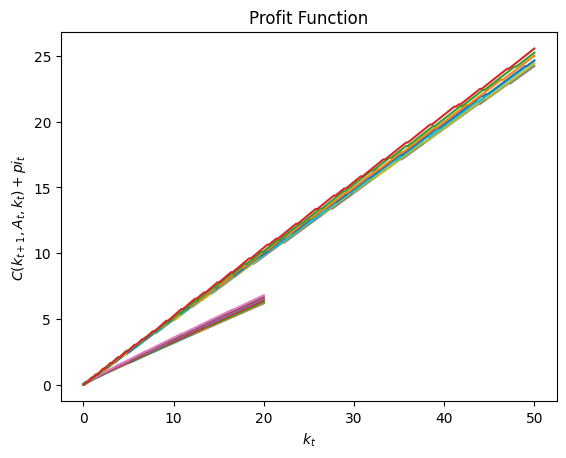

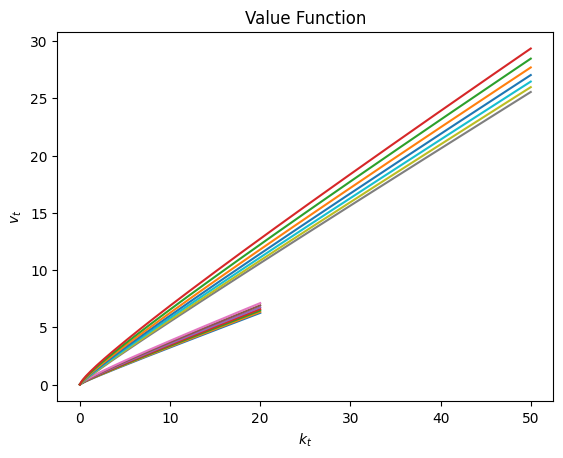

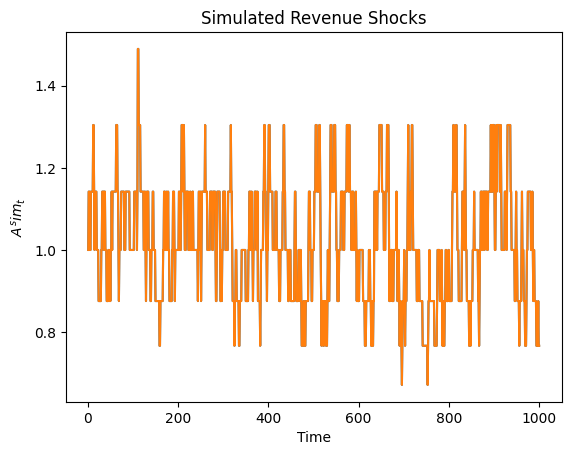

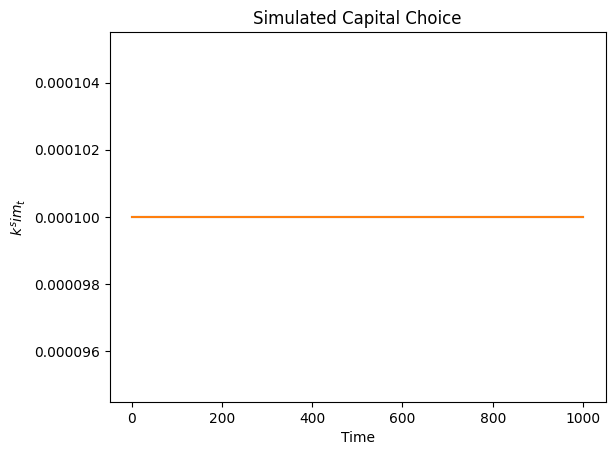

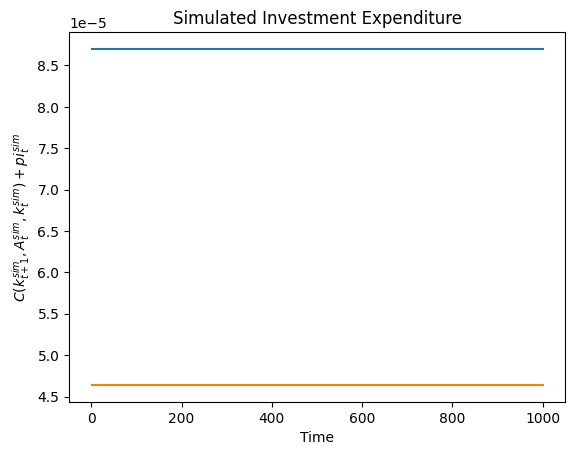

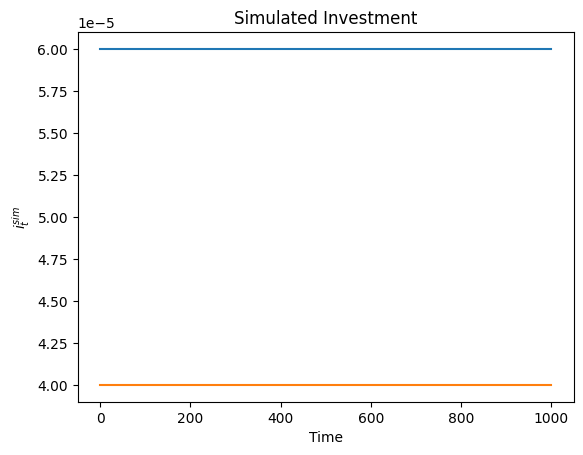

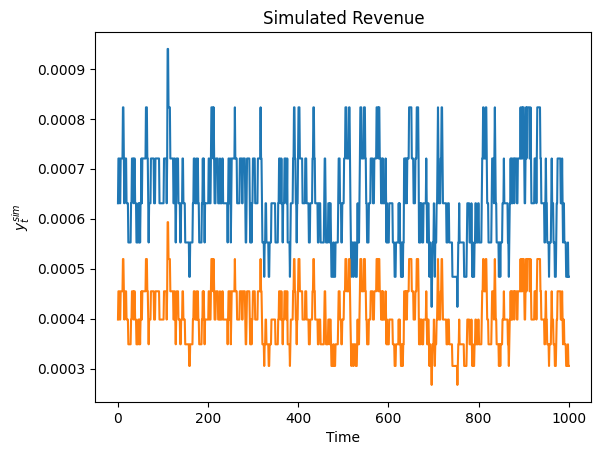

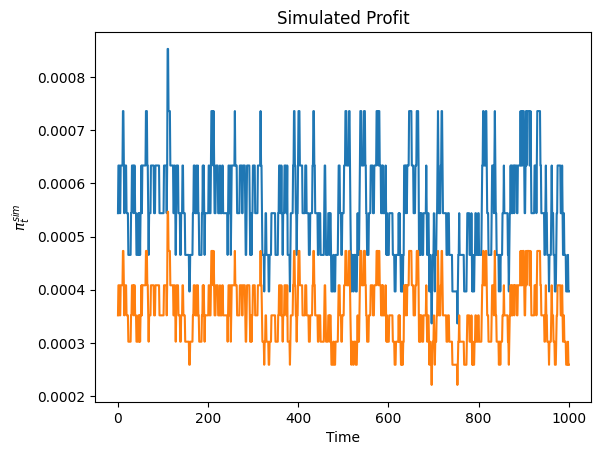

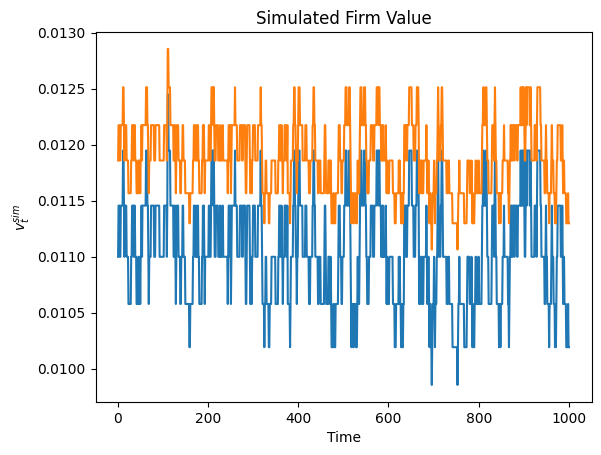

In [ ]:
small_firm_params = {
    'beta': 0.95,
    'alpha': 0.60,
    'delta': 0.60,
    'gamma': 1.5,
    'kmax': 20.0,
    'xlen': 20,
    'xmax': 10.0
}

# Define parameters for large firms.
large_firm_params = {
    'beta': 0.97,
    'alpha': 0.70,
    'delta': 0.40,
    'gamma': 0.8,
    'kmax': 50.0,
    'xlen': 40,
    'xmax': 30.0
}

# Simulate the model for small firms
print("\nSimulating model for Small Firms:")
small_company = firm()
small_company.setup(**small_firm_params, T=1000)
do_business(small_company)
earn_profit(small_company)
track_profit(small_company)

# Simulate the model for large firms
print("\nSimulating model for Large Firms:")
large_company = firm()
large_company.setup(**large_firm_params, T=1000)
do_business(large_company)
earn_profit(large_company)
track_profit(large_company)


**Simulate the model for different values of γ and δ for each type of firm**


Simulating for Small Firms with gamma=0.10 and varying delta:

Simulating with delta = 0.05
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is a dynamic model of firm investment and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The firm is infintely-lived.
   It chooses investment to maximize profit.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.95
alpha:  0.6
delta:  0.05
kmin:  0.0001
kmax:  20.0
gamma:  0.1

--------------------------------------------------------------------

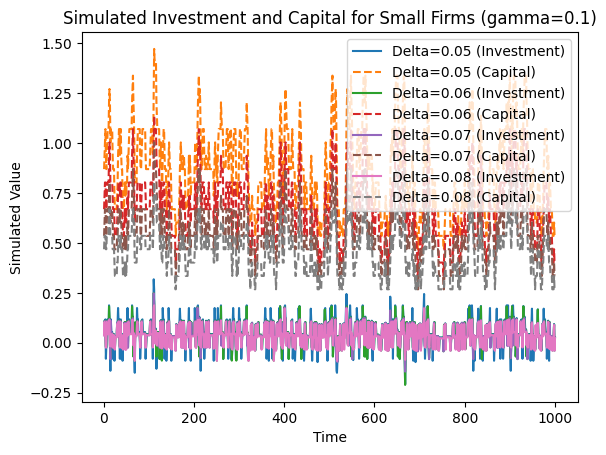

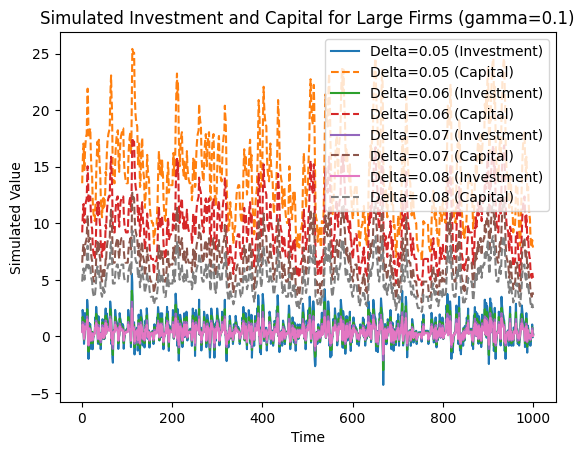

In [ ]:
# Define the ranges for delta
delta_values = [0.05, 0.06, 0.07, 0.08]
gamma_value = 0.10

# Dictionaries to store simulation results for plotting
small_firm_results = {}
large_firm_results = {}

# Simulate for small firms with gamma = 0.10 and varying delta
print("\nSimulating for Small Firms with gamma=0.10 and varying delta:")
for delta_val in delta_values:
  print(f"\nSimulating with delta = {delta_val}")
  temp_small_company = firm()
  # Use small_firm_params but override gamma and delta
  temp_params = small_firm_params.copy()
  temp_params['gamma'] = gamma_value
  temp_params['delta'] = delta_val
  temp_small_company.setup(**temp_params, T=1000)
  do_business(temp_small_company)
  earn_profit(temp_small_company)
  small_firm_results[delta_val] = {
      'ksim': temp_small_company.sim.ksim,
      'isim': temp_small_company.sim.isim
  }

# Simulate for large firms with gamma = 0.10 and varying delta
print("\nSimulating for Large Firms with gamma=0.10 and varying delta:")
for delta_val in delta_values:
  print(f"\nSimulating with delta = {delta_val}")
  temp_large_company = firm()
  # Use large_firm_params but override gamma and delta
  temp_params = large_firm_params.copy()
  temp_params['gamma'] = gamma_value
  temp_params['delta'] = delta_val
  temp_large_company.setup(**temp_params, T=1000)
  do_business(temp_large_company)
  earn_profit(temp_large_company)
  large_firm_results[delta_val] = {
      'ksim': temp_large_company.sim.ksim,
      'isim': temp_large_company.sim.isim
  }

# Plot the results for small firms
figure()
tgrid = linspace(1, small_company.par.T, small_company.par.T, dtype=int)
for delta_val in delta_values:
  plot(tgrid, small_firm_results[delta_val]['isim'], label=f'Delta={delta_val} (Investment)')
  plot(tgrid, small_firm_results[delta_val]['ksim'], linestyle='--', label=f'Delta={delta_val} (Capital)')

xlabel('Time')
ylabel('Simulated Value')
title(f'Simulated Investment and Capital for Small Firms (gamma={gamma_value})')
legend()
show()

# Plot the results for large firms
figure()
tgrid = linspace(1, large_company.par.T, large_company.par.T, dtype=int)
for delta_val in delta_values:
  plot(tgrid, large_firm_results[delta_val]['isim'], label=f'Delta={delta_val} (Investment)')
  plot(tgrid, large_firm_results[delta_val]['ksim'], linestyle='--', label=f'Delta={delta_val} (Capital)')

xlabel('Time')
ylabel('Simulated Value')
title(f'Simulated Investment and Capital for Large Firms (gamma={gamma_value})')
legend()
show()


Simulating for Small Firms with delta=0.08 and varying gamma:

Simulating with gamma = 0.1
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is a dynamic model of firm investment and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The firm is infintely-lived.
   It chooses investment to maximize profit.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.95
alpha:  0.6
delta:  0.08
kmin:  0.0001
kmax:  20.0
gamma:  0.1

---------------------------------------------------------------------

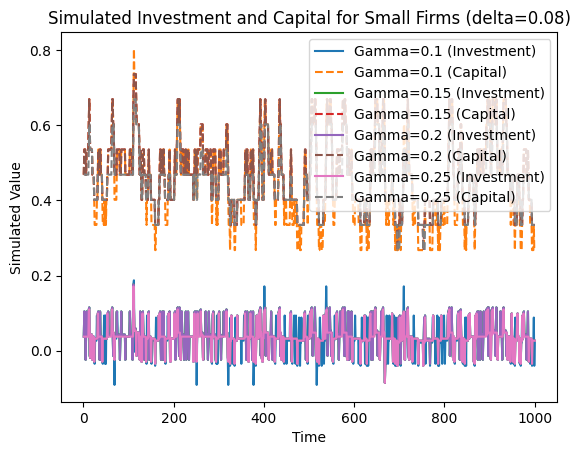

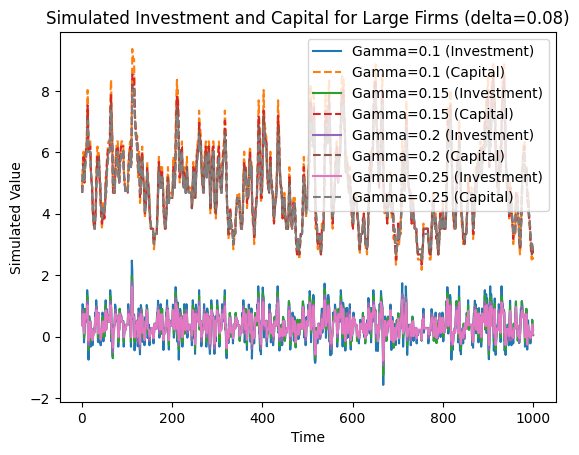

In [ ]:
# Define the ranges for gamma and delta
gamma_values = [0.10, 0.15, 0.20, 0.25]
delta_value = 0.08

# Dictionaries to store simulation results for plotting
small_firm_results_combo = {}
large_firm_results_combo = {}

# Simulate for small firms with delta = 0.08 and varying gamma
print("\nSimulating for Small Firms with delta=0.08 and varying gamma:")
for gamma_val in gamma_values:
  print(f"\nSimulating with gamma = {gamma_val}")
  temp_small_company = firm()
  # Use small_firm_params but override gamma and delta
  temp_params = small_firm_params.copy()
  temp_params['gamma'] = gamma_val
  temp_params['delta'] = delta_value
  temp_small_company.setup(**temp_params, T=1000)
  do_business(temp_small_company)
  earn_profit(temp_small_company)
  small_firm_results_combo[gamma_val] = {
      'ksim': temp_small_company.sim.ksim,
      'isim': temp_small_company.sim.isim
  }

# Simulate for large firms with delta = 0.08 and varying gamma
print("\nSimulating for Large Firms with delta=0.08 and varying gamma:")
for gamma_val in gamma_values:
  print(f"\nSimulating with gamma = {gamma_val}")
  temp_large_company = firm()
  # Use large_firm_params but override gamma and delta
  temp_params = large_firm_params.copy()
  temp_params['gamma'] = gamma_val
  temp_params['delta'] = delta_value
  temp_large_company.setup(**temp_params, T=1000)
  do_business(temp_large_company)
  earn_profit(temp_large_company)
  large_firm_results_combo[gamma_val] = {
      'ksim': temp_large_company.sim.ksim,
      'isim': temp_large_company.sim.isim
  }

# Plot the results for small firms with delta = 0.08 and varying gamma
figure()
tgrid = linspace(1, small_company.par.T, small_company.par.T, dtype=int)
for gamma_val in gamma_values:
  plot(tgrid, small_firm_results_combo[gamma_val]['isim'], label=f'Gamma={gamma_val} (Investment)')
  plot(tgrid, small_firm_results_combo[gamma_val]['ksim'], linestyle='--', label=f'Gamma={gamma_val} (Capital)')

xlabel('Time')
ylabel('Simulated Value')
title(f'Simulated Investment and Capital for Small Firms (delta={delta_value})')
legend()
show()

# Plot the results for large firms with delta = 0.08 and varying gamma
figure()
tgrid = linspace(1, large_company.par.T, large_company.par.T, dtype=int)
for gamma_val in gamma_values:
  plot(tgrid, large_firm_results_combo[gamma_val]['isim'], label=f'Gamma={gamma_val} (Investment)')
  plot(tgrid, large_firm_results_combo[gamma_val]['ksim'], linestyle='--', label=f'Gamma={gamma_val} (Capital)')

xlabel('Time')
ylabel('Simulated Value')
title(f'Simulated Investment and Capital for Large Firms (delta={delta_value})')
legend()
show()


Simulating with gamma = 0.1, delta = 0.05
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is a dynamic model of firm investment and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The firm is infintely-lived.
   It chooses investment to maximize profit.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.97
alpha:  0.7
delta:  0.05
kmin:  0.0001
kmax:  50.0
gamma:  0.1

--------------------------------------------------------------------------------------------------
Solving the Model b

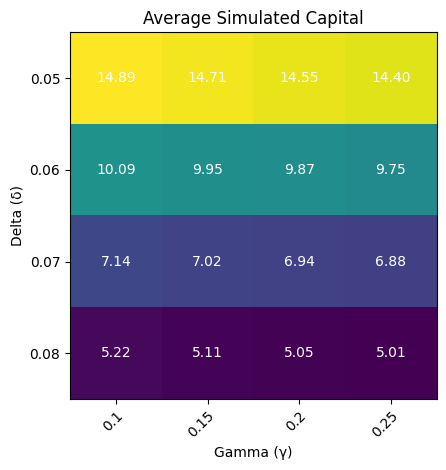

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ranges for gamma and delta
gamma_values = [0.10, 0.15, 0.20, 0.25]
delta_values = [0.05, 0.06, 0.07, 0.08]

# Dictionary to store average simulated capital for each combination
average_capital_results = {}

# Iterate through each combination of gamma and delta
for gamma_val in gamma_values:
  for delta_val in delta_values:
    print(f"\nSimulating with gamma = {gamma_val}, delta = {delta_val}")
    temp_company = firm()
    temp_params = large_firm_params.copy()
    temp_params['gamma'] = gamma_val
    temp_params['delta'] = delta_val
    temp_company.setup(**temp_params, T=500)
    do_business(temp_company)
    earn_profit(temp_company)

    # Compute the average simulated capital
    average_capital = np.nanmean(temp_company.sim.ksim)
    average_capital_results[(gamma_val, delta_val)] = average_capital

# Prepare data for the heatmap
heatmap_data = np.zeros((len(delta_values), len(gamma_values)))
for i, delta_val in enumerate(delta_values):
  for j, gamma_val in enumerate(gamma_values):
    heatmap_data[i, j] = average_capital_results[(gamma_val, delta_val)]

# Create the heatmap
fig, ax = plt.subplots()
im = ax.imshow(heatmap_data, cmap="viridis")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(gamma_values)))
ax.set_yticks(np.arange(len(delta_values)))
ax.set_xticklabels(gamma_values)
ax.set_yticklabels(delta_values)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(delta_values)):
  for j in range(len(gamma_values)):
    text = ax.text(j, i, f"{heatmap_data[i, j]:.2f}",
                       ha="center", va="center", color="w")

ax.set_xlabel('Gamma (γ)')
ax.set_ylabel('Delta (δ)')
ax.set_title('Average Simulated Capital')

fig.tight_layout()
plt.show()